In [2]:
#testing the missingno package to plot the completeness of patient data 


In [2]:
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
import seaborn as sns

In [4]:
#this contains the information for a patient class
#creates a class for patients so we can call information about them easily
#this contains the information for a patient class
#creates a class for patients so we can call information about them easily
class patient:
    def __init__(self, filepath, input_fileName, lengthPtID):
        ptID = input_fileName[:lengthPtID]
        self.ptID = ptID
        self.fileName = input_fileName
        #find the demographics in one of two sheets
        # directory = os.getcwd()
        file_adds = filepath + '/' + input_fileName
        file = pd.ExcelFile(file_adds)
        sheet_Names = file.sheet_names
        if 'Cancer_Registery Data' in sheet_Names:
            #do the thing for getting patient info
            df = pd.read_excel(input_fileName, sheet_name= 'Cancer_Registery Data')
            self.ptDemographics = df
            self.amyloid_status = df.at[0,"Amyloid Status"]
            self.survival = df.at[0,"Survival Time (Months)"]
            self.ageDx = df.at[0,"Age At Diagnosis"] 
            self.sex = df.at[0,"Gender Cancer Registry"]
            self.vitalStatus = df.at[0, "Vital Status Cancer Registry"]
            self.dx = df.at[0, "Histology"]

        elif '30 Cerner Patients ' in sheet_Names:
            #do the thing for getting patient info
            df = pd.read_excel(input_fileName, sheet_name= '30 Cerner Patients ')
            self.ptDemographics = df
            self.amyloid_status = df.at[0,"Amyloid Status"]
            self.survival = df.at[0,"Survival Time (months)"]
            self.ageDx = df.at[0,"Age At Diagnosis"] 
            self.sex = df.at[0,"Gender Cerner"]
            self.vitalStatus = df.at[0, "Vital Status (Cerner)"]
            self.dx = df.at[0, "Primary Site"]


        else: print("no patient identifying information")

        #now iterate through the list of sheets to import the patient data 
        if 'Labs' in sheet_Names:
            self.labsData = pd.read_excel(input_fileName, sheet_name= 'Labs')
        else: self.labsData = False
        
        if 'amyloid in subject' in sheet_Names:
            self.echoData = pd.read_excel(input_fileName, sheet_name= 'amyloid in subject')
        else: self.echoData = False

        if 'ChemoTx' in sheet_Names:
            self.ChemoTx = pd.read_excel(input_fileName, sheet_name= 'ChemoTx')
        else: self.ChemoTx = False

        if 'Hematologic Tx' in sheet_Names:
            self.HemeTx = pd.read_excel(input_fileName, sheet_name= 'Hematologic Tx')
        else: self.HemeTx = False

        if 'Immuno Tx' in sheet_Names:
            self.HemeTx = pd.read_excel(input_fileName, sheet_name= 'Immuno Tx')
        else: self.ImmunoTx = False

        if 'Radiation Tx' in sheet_Names:
            self.RadTx = pd.read_excel(input_fileName, sheet_name= 'Radiation Tx')
        else: self.ImmunoTx = False

        if 'Physican_Notes' in sheet_Names:
            self.MDnotes = pd.read_excel(input_fileName, sheet_name= 'Physican_Notes')
        else: self.MDnotes = False

        #to create a callable list of treatments recieved for which we have data
        tx_sheets = ['ChemoTx', 'Hematologic Tx', 'Immuno Tx']
        treatmentTypesRecieved = []

        for possible in tx_sheets:
        
            if possible in sheet_Names:
                treatmentTypesRecieved.append(possible)
        self.txRecieved = treatmentTypesRecieved

def FilterList(list, keyWords_primary, keyWords_secondary = ["Empty"], omit = ["Empty"]):
    #store the filtered result
    filteredList = []

    if keyWords_secondary == ["Empty"]:
        for c in list: #loop the columns
            for buzz in keyWords_primary: #loop the key words
                if buzz in c: #if the column contains the key word
                    filteredList.append(c) #add the column to the list
                    break #do not continue testing primary key words for this column
    
    else: 
        for c in list: #loop the columns
            for buzz in keyWords_primary: #loop the key words
                if buzz in c: #if the column contains the key word
                    for secondary in keyWords_secondary:
                        if secondary in c:
                            filteredList.append(c) #add the column to the list
                            break #has been added to list based on passing the seondary 
                        else:
                            pass
                    break #do not continue to check primary key words for this column
                else:
                    pass
                
    if omit != ["Empty"]: 
        for x in omit: 
            for a in filteredList:
                if x in a:
                    filteredList.remove(a)
    
    #by iterating through the column names first, we keep the order of the columns

    return filteredList 


#createBinary function
def createBinary(df, listOfLabs, timeColumn): 
    #list of labs needs to match exactly.  
    # Filter the dataframe before inputting
    #for boolean
    df_toBool = df[listOfLabs]
    df_bool = df_toBool.notna()
    df_asint = df_bool.astype(int)
    #add column back for time 
    df_asint.insert(0, timeColumn, df[timeColumn])
    return df_asint

def createBinarySum(df, listOfLabs, timeColumn):
    #list of labs needs to match exactly.  
    # Filter the dataframe before inputting
    #for boolean
    df_toBool = df[listOfLabs]
    df_bool = df_toBool.notna()
    df_asint = df_bool.astype(int)
    #add column back for time 
    df_asint.insert(0, timeColumn, df[timeColumn])
    #sum across the row
    df_new_sum = df_asint.sum(axis = 1)
    return df_new_sum

#get list of patients from directory 
def GetListOfPatientsFromDirectory (directory, fileExtension, fileCommon, lengthID):
    #get the directory 
    listFileNames = os.listdir(directory)
    outputList = []
    #loop through list of fileNames: 
    for file in listFileNames:
        #id if the file is patient data
        if fileCommon in file and file.endswith(fileExtension):
            #trim the file name to the pt ID
            ptID = file[:lengthID]
            outputList.append(ptID)
    return outputList

def GetListofPTfiles(directory, fileExtension, fileCommon):
    listFileNames = os.listdir(directory)
    outListFiles = []
    #loop through file names
    for file in listFileNames:
        if fileCommon in file and file.endswith(fileExtension):
            outListFiles.append(file)
    return outListFiles

#get amyloid status dictionary inputs, sort ptIDs to lists based on amyloid status 
def getListSortedByAmyloid(amyloidDictionary, listPositive, listNegative, listOther,
                           statusPositive = "yes", statusNegative = "no"):
    for pt in amyloidDictionary.keys():
        status = amyloidDictionary[pt]
        if status == statusPositive:
            listPositive.append(pt)
        elif status == statusNegative:
            listNegative.append(pt)
        else:
            listOther.append(pt)
    #does not check for double listed patient IDs

In [5]:
#directory
starting_directory = os.getcwd()

new_dirrectory = 'C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/data-2024-06-05'
os.chdir(new_dirrectory)

In [6]:
ordersets_dict = {
    "CBC with Coag" : ["Hemoglobin","Platelet Count", "INR","WBC", "Blast","Coombs", 
                       "Immature Gran", "Monocyte", "Neutrophil", "RBC"],
    "Light Chains" : ["Beta-2", "Kappa Free Light Chains", "Lambda Free Light Chains", 
                      "Free Light Chain Ratio"],
    "Serum Electrophoresis" : ["Serum Electrophoresis", "Serum Immunologic"],
    "CMP with LDH" : ["BUN", "Creatinine Result","Uric Acid","Albumin Result","Serum Protein", "LDH"],
    "Urinalysis" : ["Total Urine Protein", "Urine Albumin", "Urinalysis Alpha1", "Urinalysis Alpha2",
                        "Urinaysis Beta Globulin", "Urinalysis Gamma Golubulin", "Urinalysis M Spike",
                        "Urine Osmolality", "Urine Specific Gravity"],
    "Cardiac Labs" : ["BNP","Troponin-T"],
    "Serum-Urine-LightChains" : ["Serum Electrophoresis", "Serum Immunologic","Total Urine Protein", 
                                 "Urine Albumin", "Urinalysis Alpha1", "Urinalysis Alpha2",
                                 "Urinaysis Beta Globulin", "Urinalysis Gamma Golubulin", "Urinalysis M Spike",
                                 "Urine Osmolality", "Urine Specific Gravity", "Beta-2", 
                                 "Kappa Free Light Chains", "Lambda Free Light Chains", "Free Light Chain Ratio"]
} 

ordersets_secondary = {
    "CBC with Coag" : ["Result"],
    "Light Chains" : ["Result"],
    "Serum Electrophoresis" : ["Result"],
    "CMP with LDH" : ["Result"],
    "Urinalysis" : ["Result"],
    "Cardiac Labs" : ["Empty"],
    "Serum-Urine-LightChains" : ["Result"]
}

ordersets_omit = {
    "CBC with Coag" : ["Urinalysis", "Method", "Nucleated RBC/100 WBC Result Method"],
    "Light Chains" : ["Method"],
    "Serum Electrophoresis" : ["Method"],
    "CMP with LDH" : ["Method"],
    "Urinalysis" : ["Method"],
    "Cardiac Labs" : ["Empty"],
    "Serum-Urine-LightChains" : ["Method"]
}

In [16]:
#importing patient data to pd
ptID_test = "E-01"

#build a dictionary of patients and their values 
ptFiles = GetListofPTfiles(new_dirrectory, '.xlsx', 'data')

patientDictAmyloid = {}
patientDictSurvival = {}
patientDictLabs = {}
patientDictEcho = {}

#loop through the listOfPatients 
for file in ptFiles: 
    pt = patient(new_dirrectory, file, 4)
    patientDictAmyloid[pt.ptID] = pt.amyloid_status
    patientDictSurvival[pt.ptID] = pt.survival
    patientDictLabs[pt.ptID] = pt.labsData
    patientDictEcho[pt.ptID] = pt.echoData

#calling patient to test 
ptLabsTest = patientDictLabs[ptID_test]

In [17]:
#keywords by group
kwPrimary_bloodGeneral = ["Hemoglobin","Platelet Count", "INR","WBC", "Blast","Coombs", "Immature Gran", "Monocyte", "Neutrophil", "RBC"]
kwPrimary_LightChains =["LDH","Beta-2", "Kappa Free Light Chains", "Lambda Free Light Chains", "Free Light Chain Ratio"]
kwPrimary_SerumElectrophoresis = ["Serum Electrophoresis", "Serum Immunologic"]
kwPrimary_metabolic = ["BUN", "Creatinine Result","Uric Acid","Albumin Result","Serum Protein"]
kwPrimary_Urine = ["Total Urine Protein", "Urine Albumin", "Urinalysis Alpha1", "Urinalysis Alpha2",
                    "Urinaysis Beta Globulin", "Urinalysis Gamma Golubulin", "Urinalysis M Spike",
                    "Urine Osmolality", "Urine Specific Gravity"]
kwPrimary_Cardiac = ["BNP","Troponin-T"]

#all key words
keywords_Primary = ["BUN", "Albumin Result", "Creatinine Result",
                    "Hemoglobin", "Platelet Count", "INR", "Kappa Free Light Chains",
                    "Lambda Free Light Chains", "Free Light Chain Ratio",
                    "Total Urine Protein", "Urine Albumin", "Urinalysis Alpha1", "Urinalysis Alpha2",
                    "Urinaysis Beta Globulin", "Urinalysis Gamma Golubulin", "Urinalysis M Spike", "BNP",
                    "Troponin-T", "Beta-2", "LDH", "Uric Acid", "Serum Protein", "WBC", "Blast",
                    "Coombs", "Immature Gran", "Monocyte", "Neutrophil", "RBC", "Serum Electrophoresis",
                    "Serum Immunologic", "Urine Osmolality", "Urine Specific Gravity"]

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.

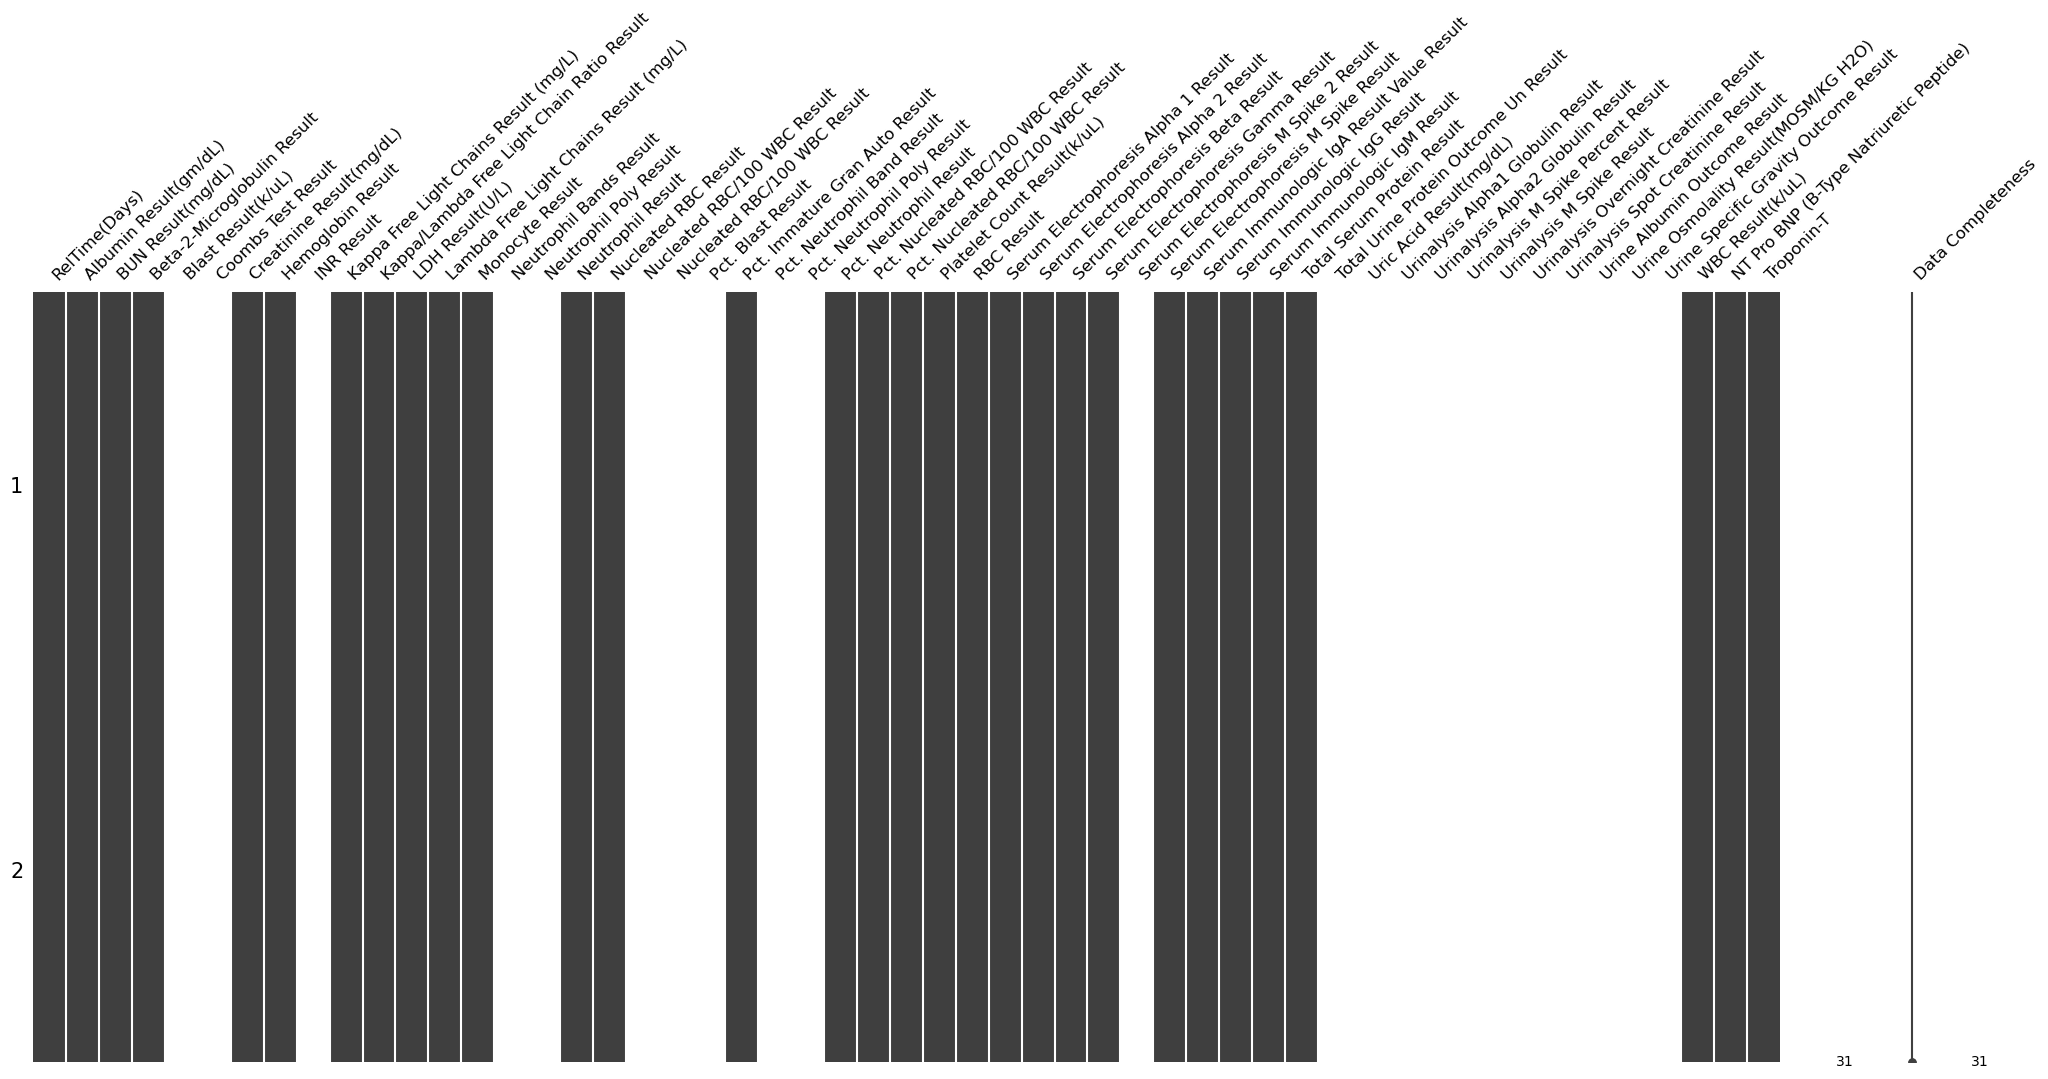

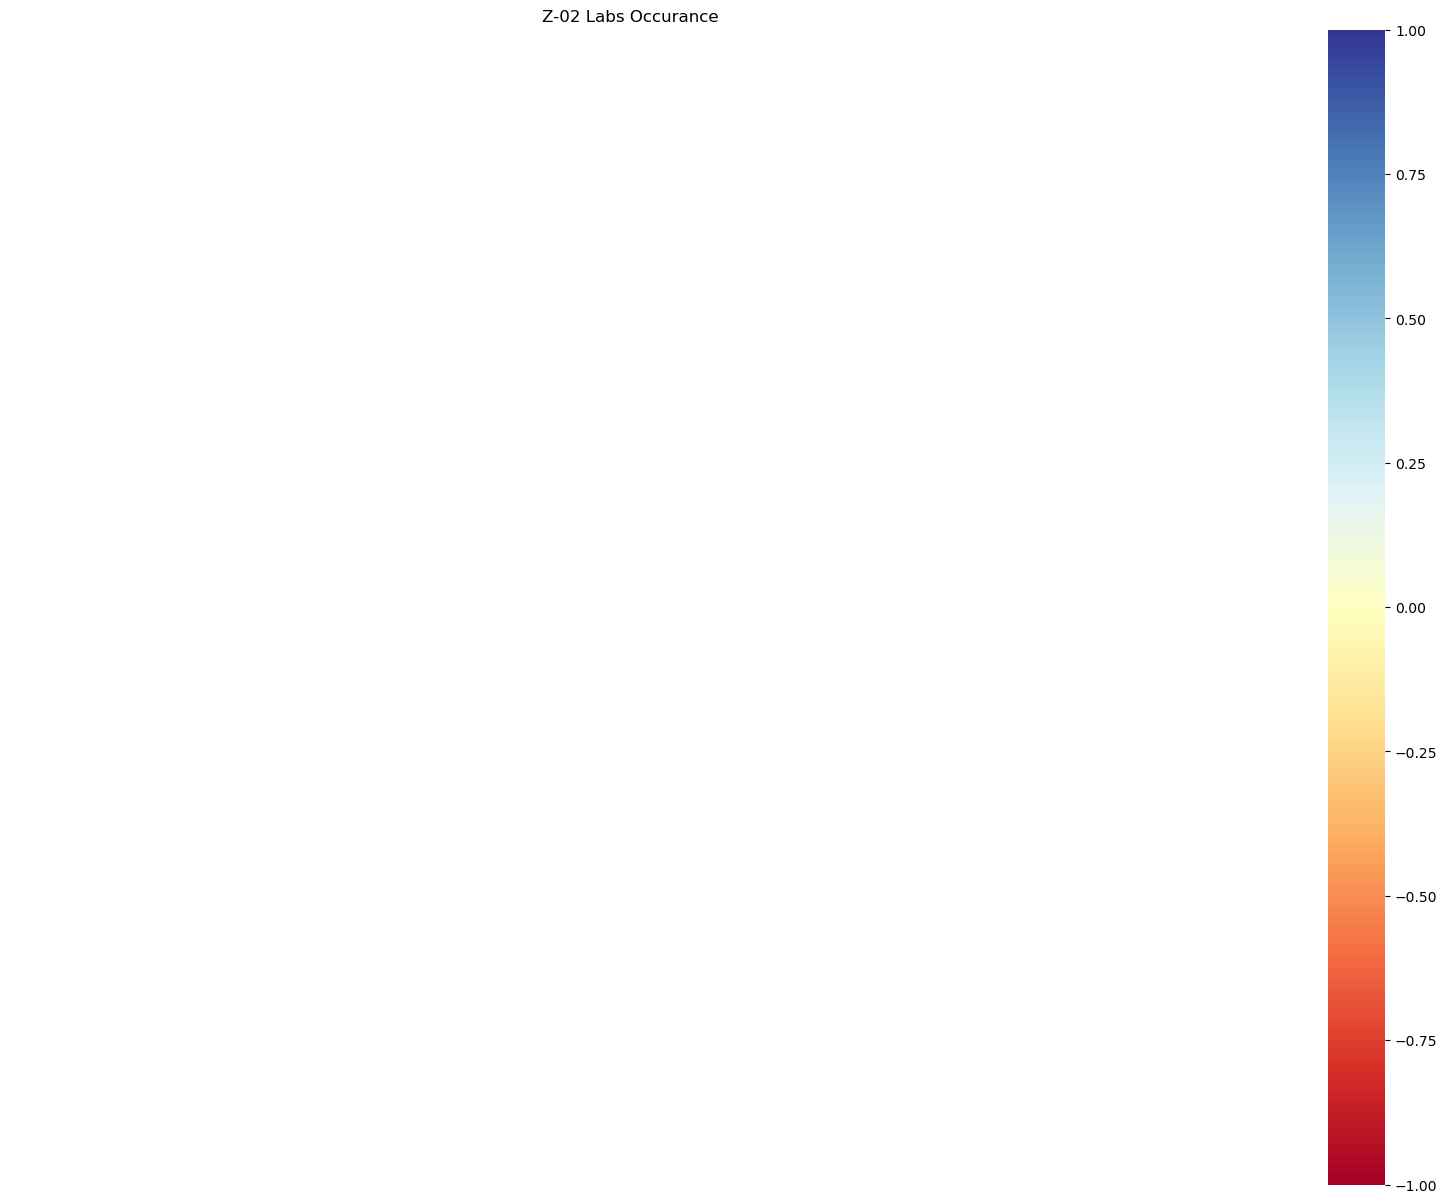

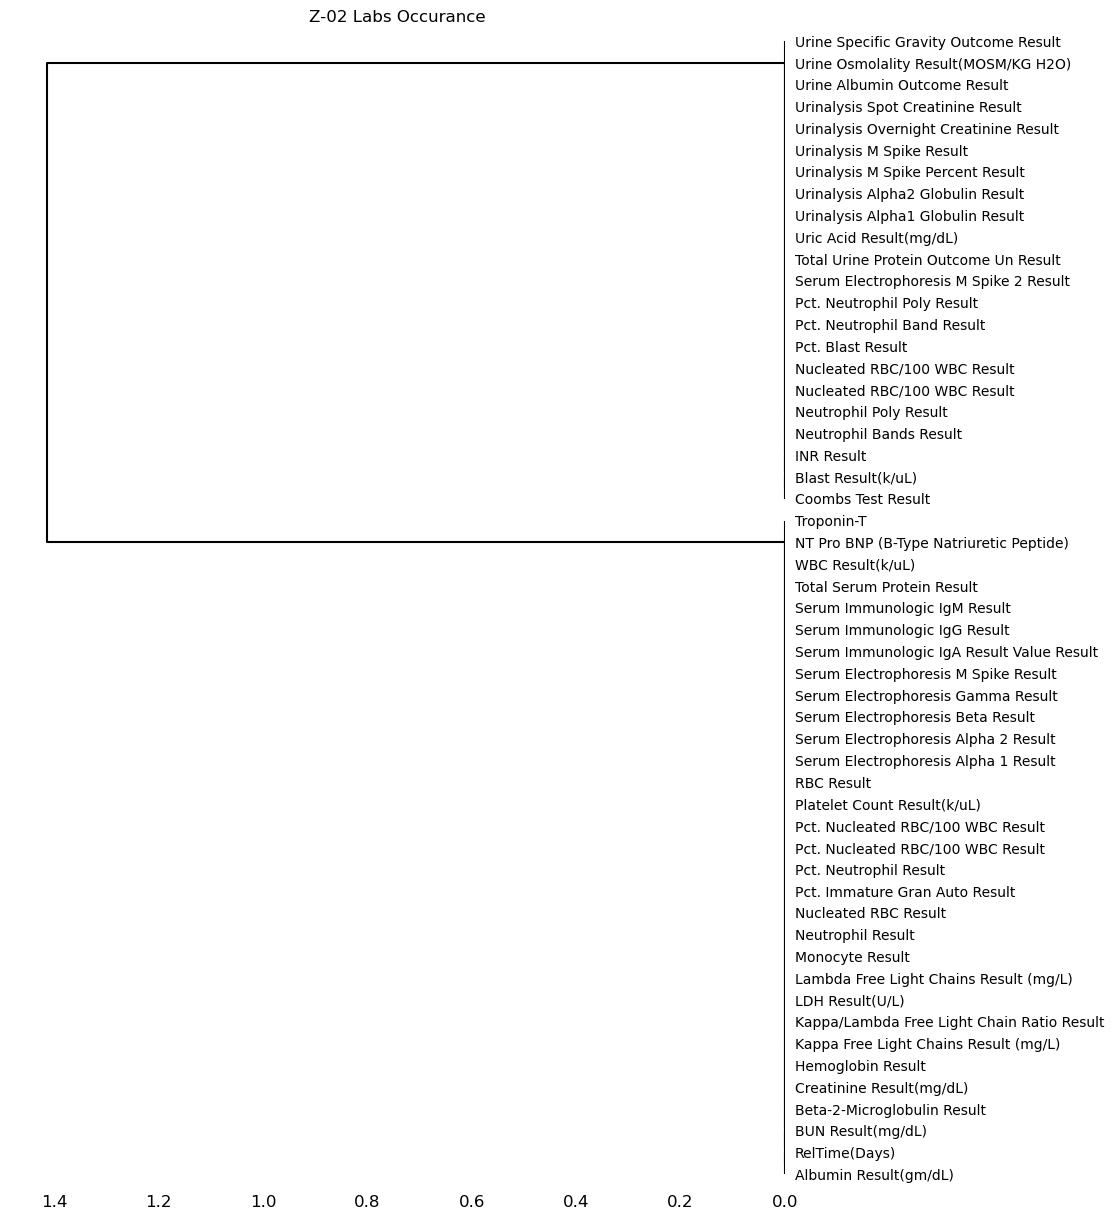

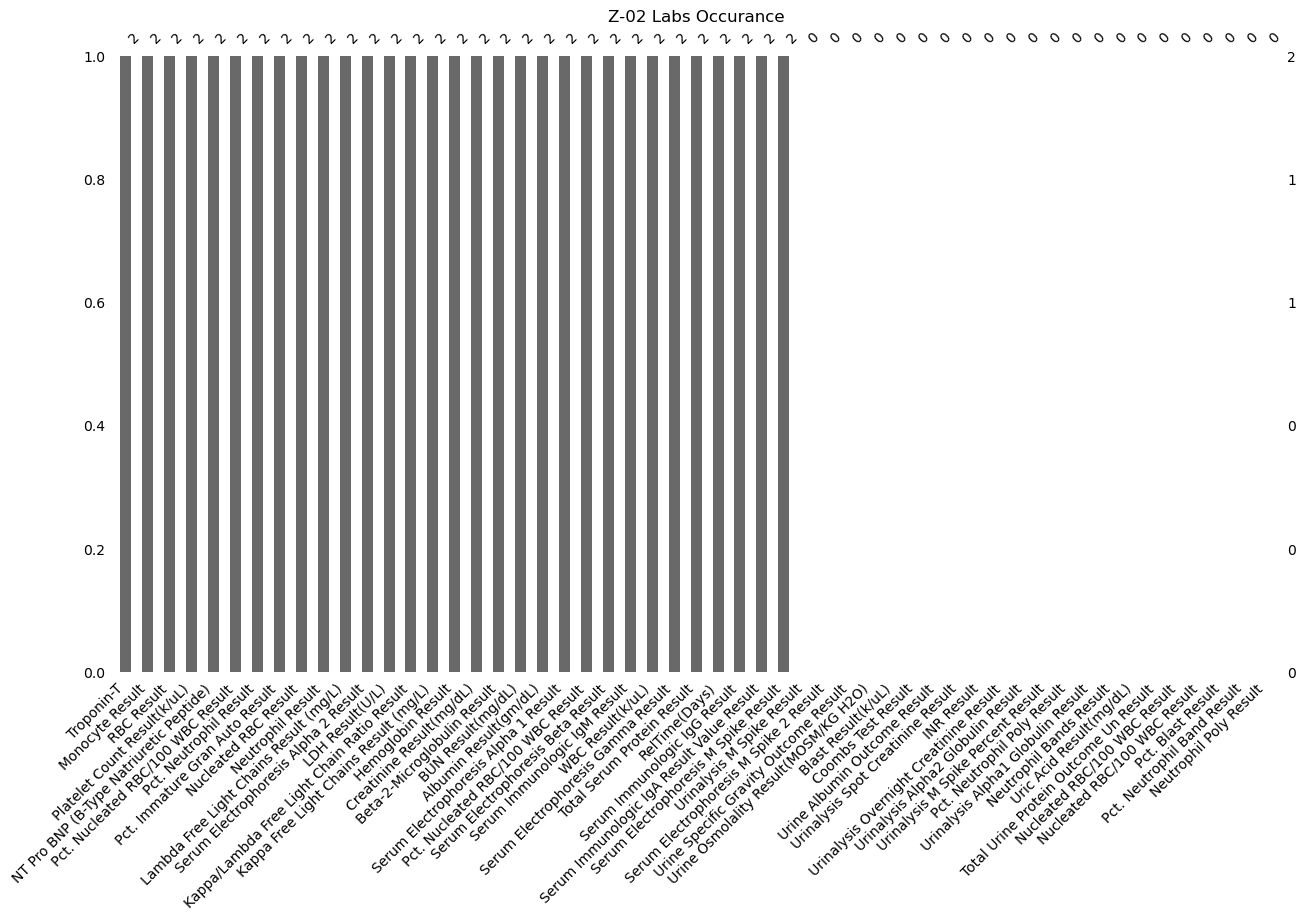

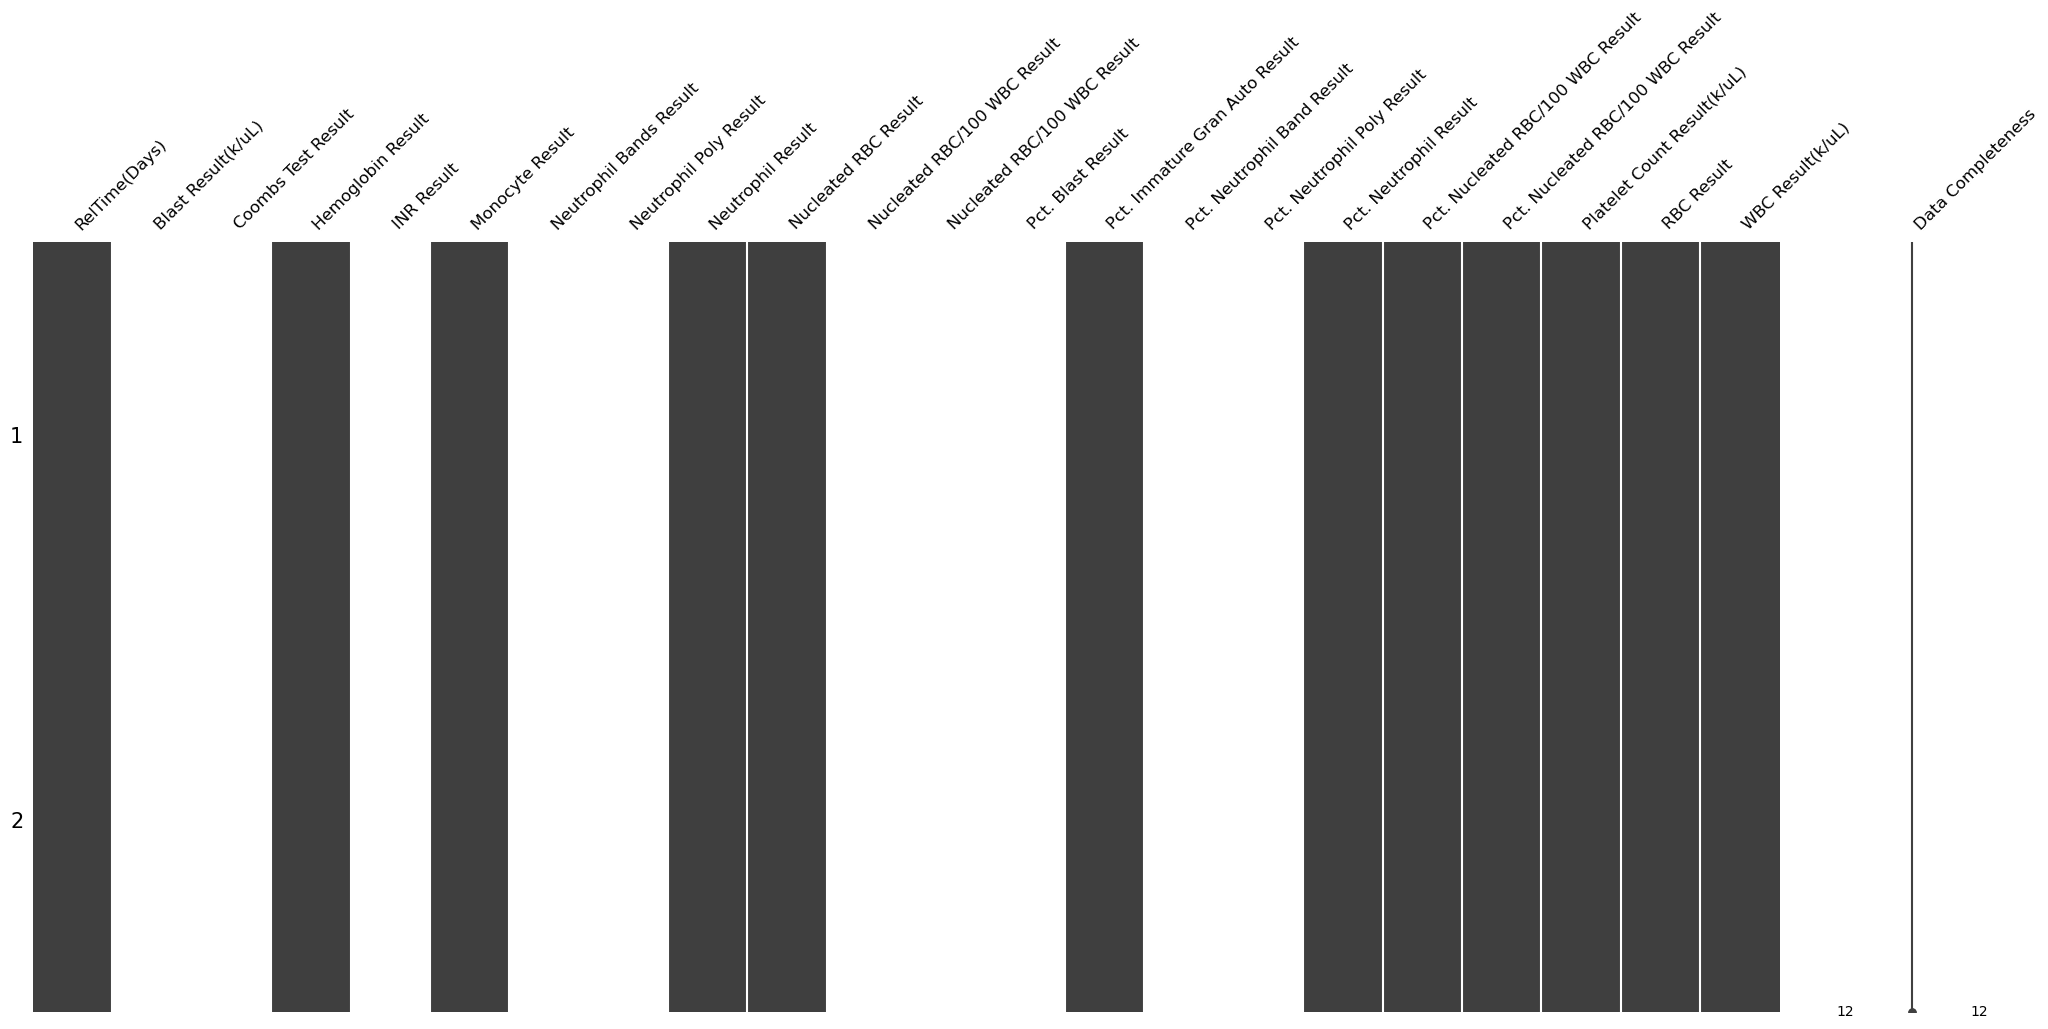

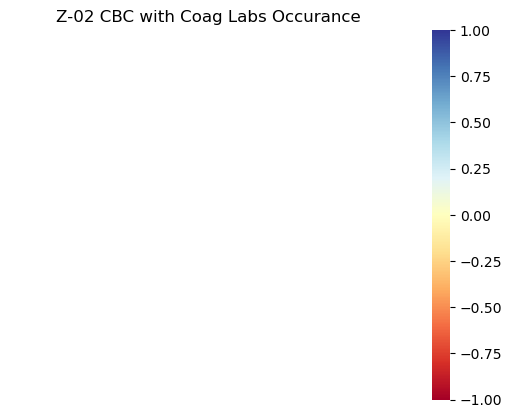

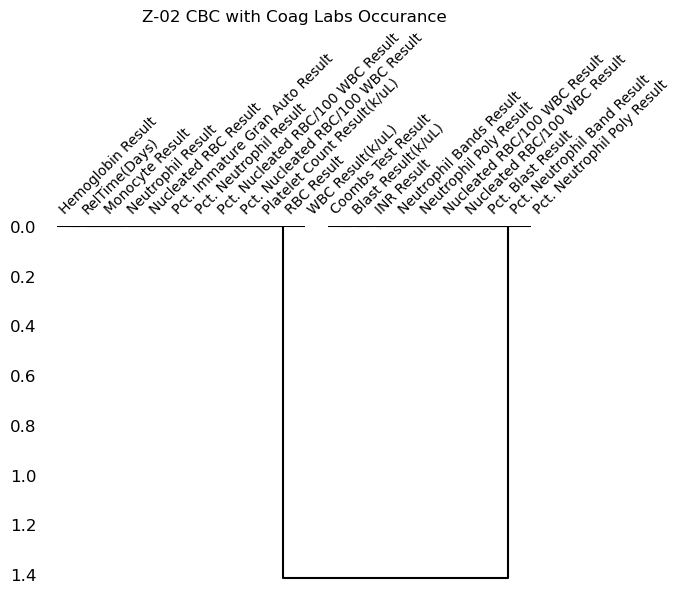

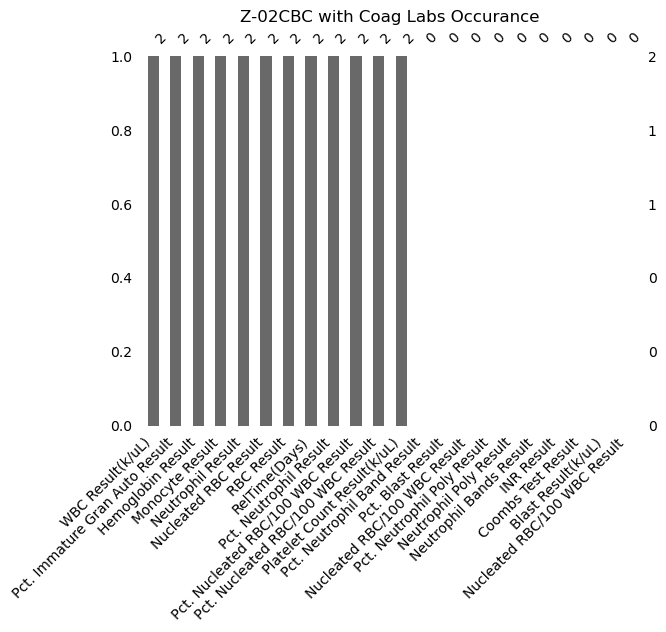

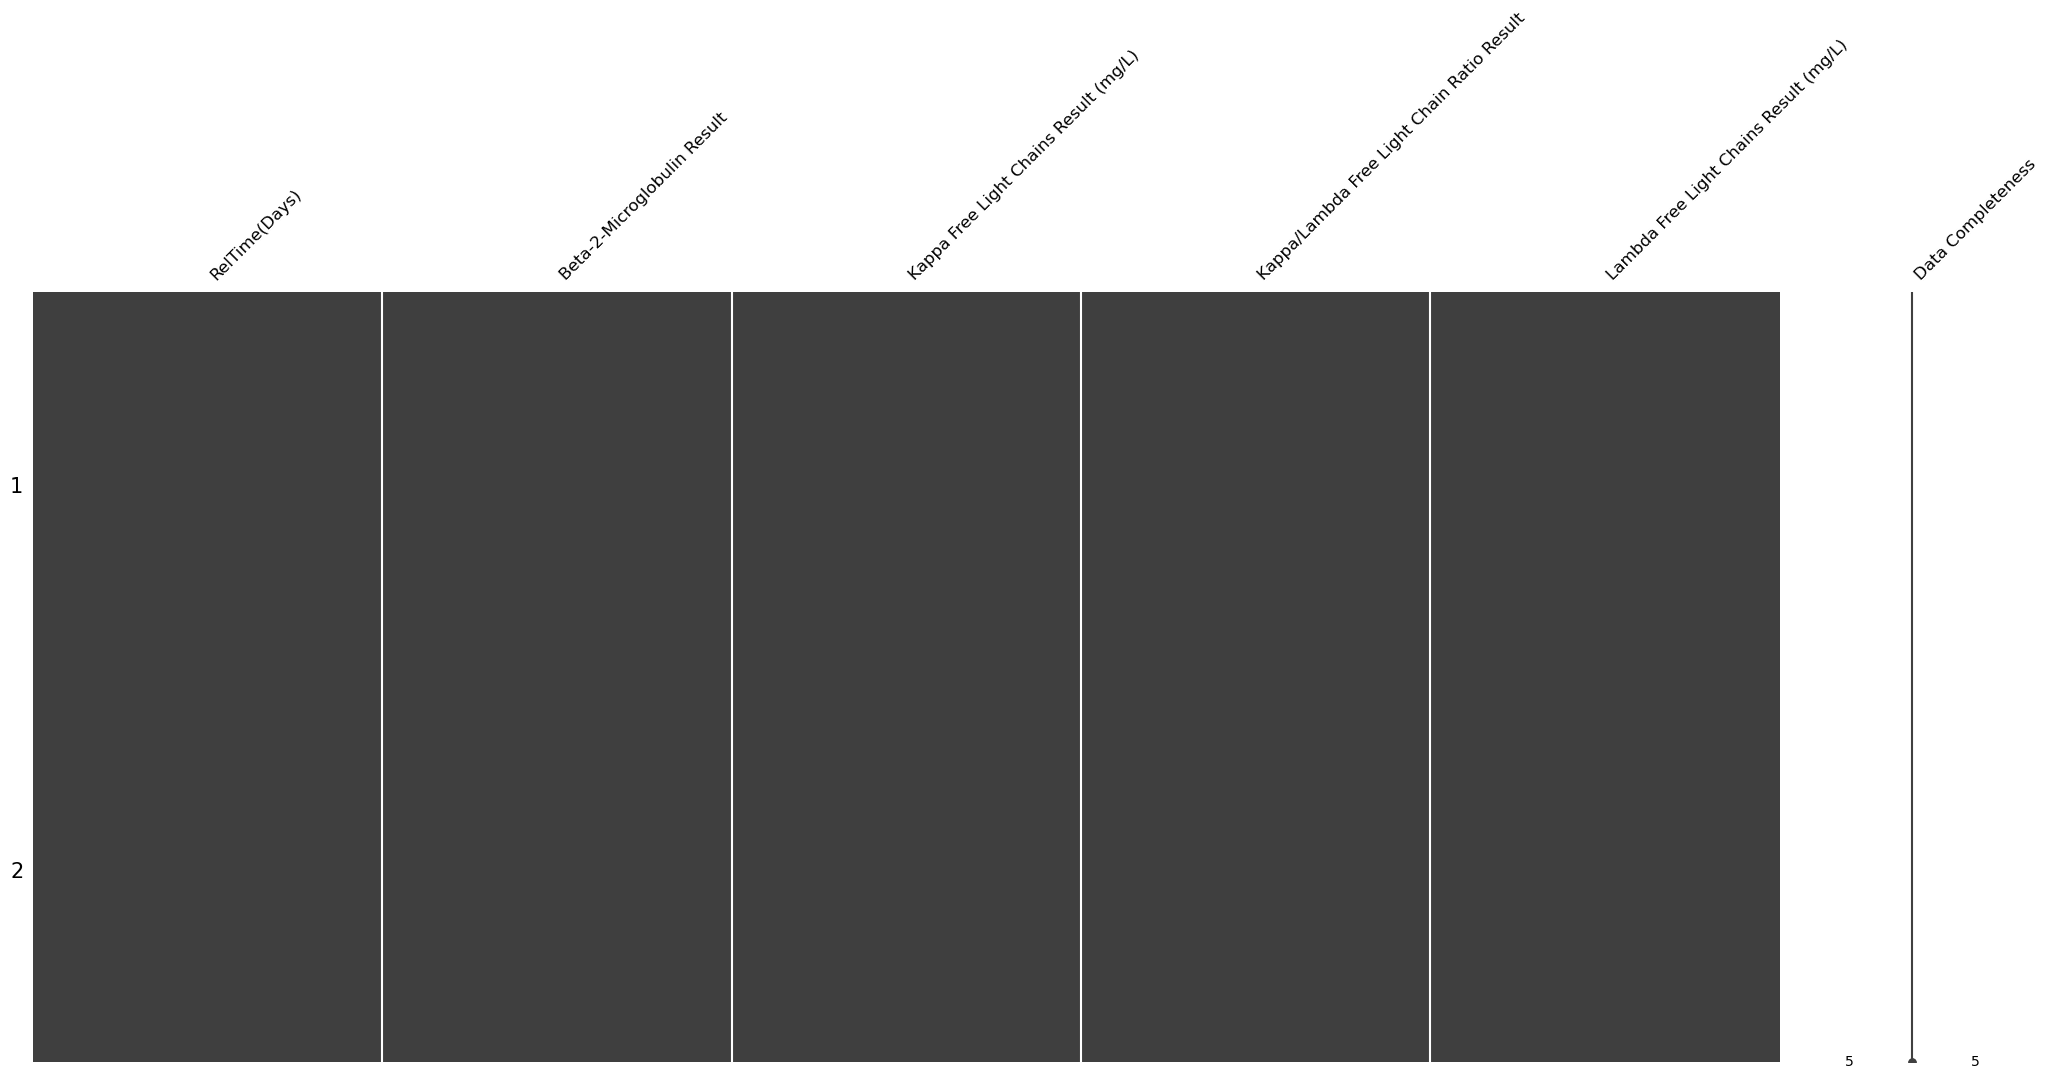

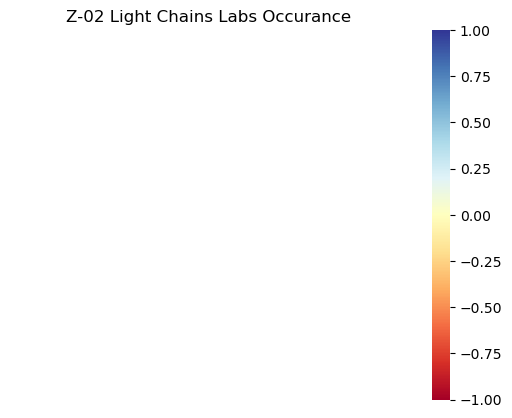

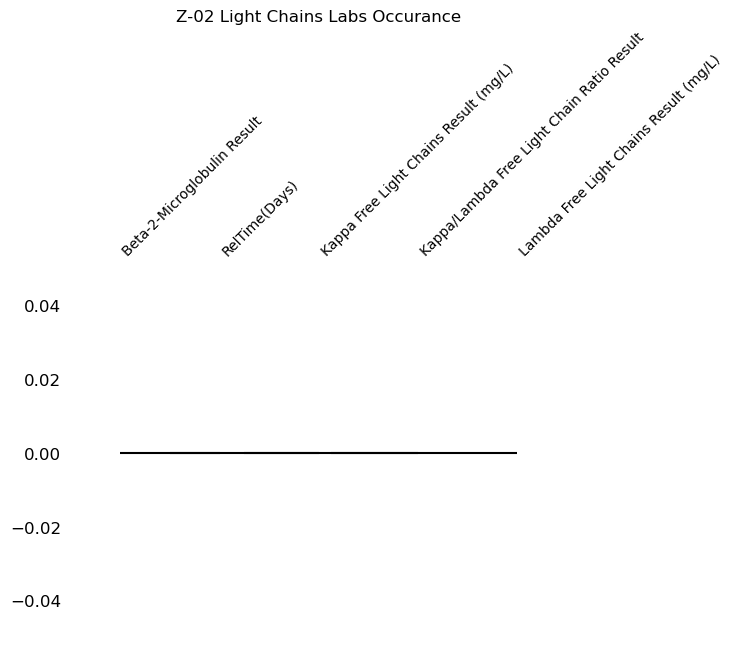

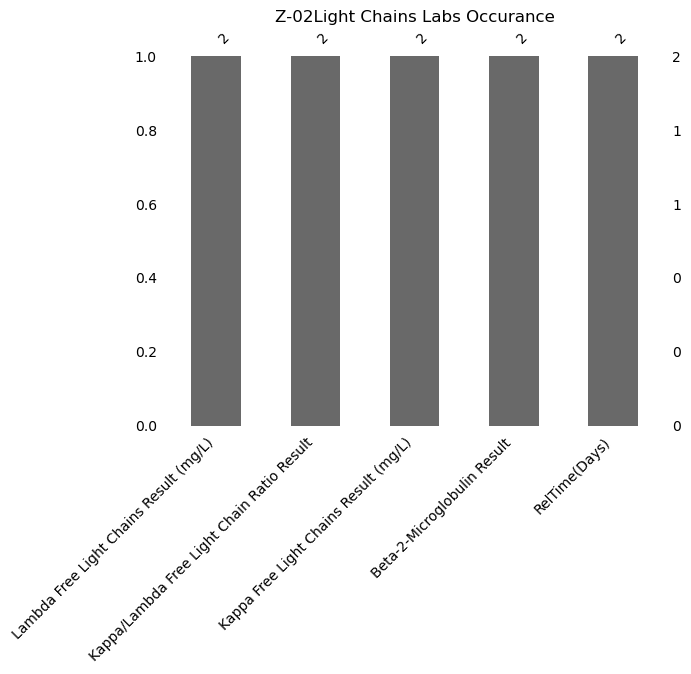

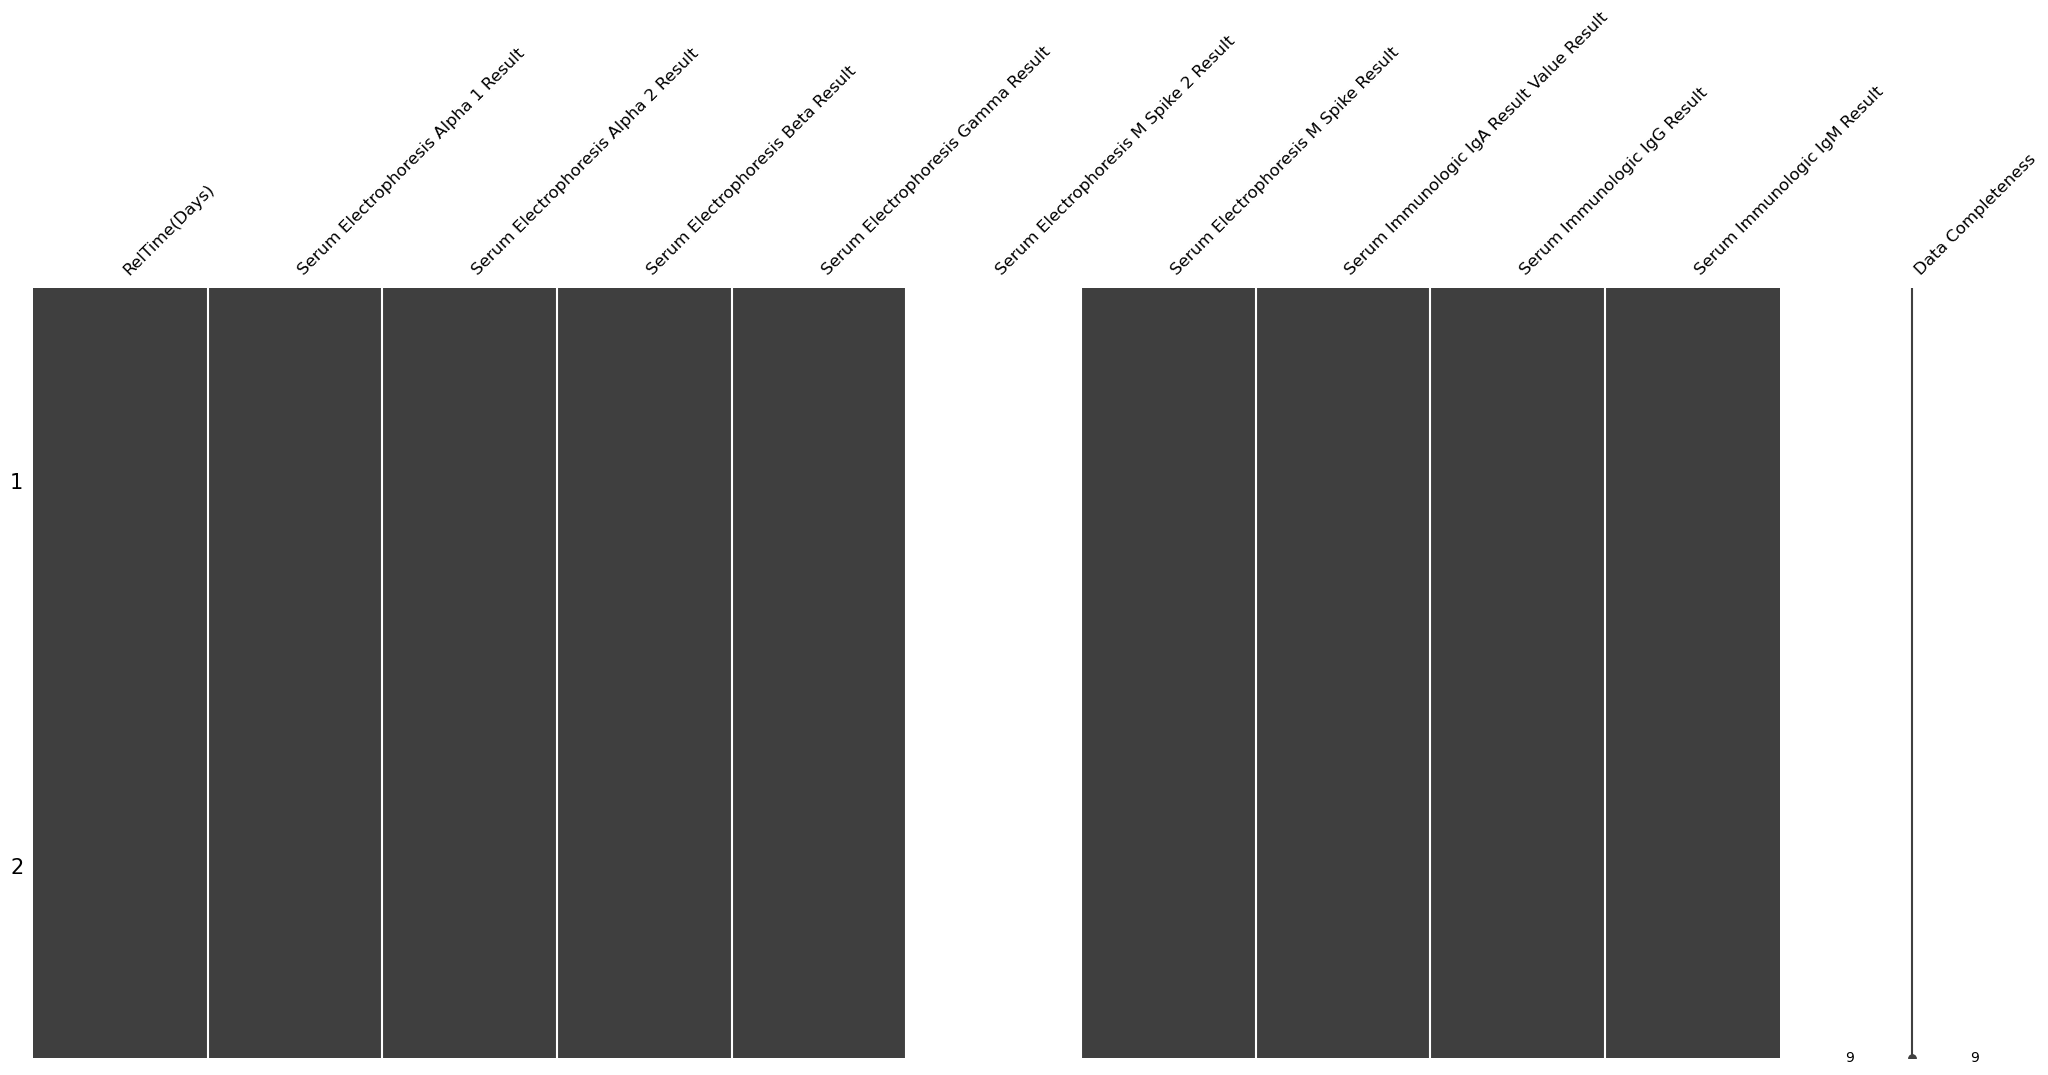

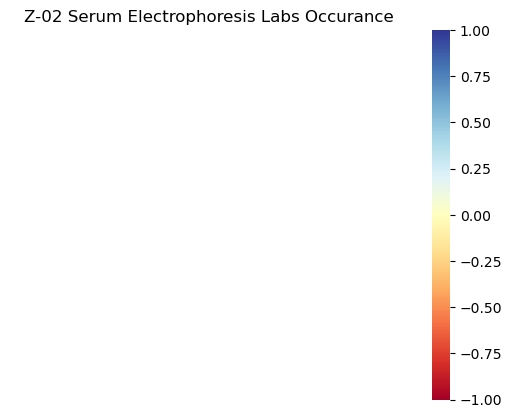

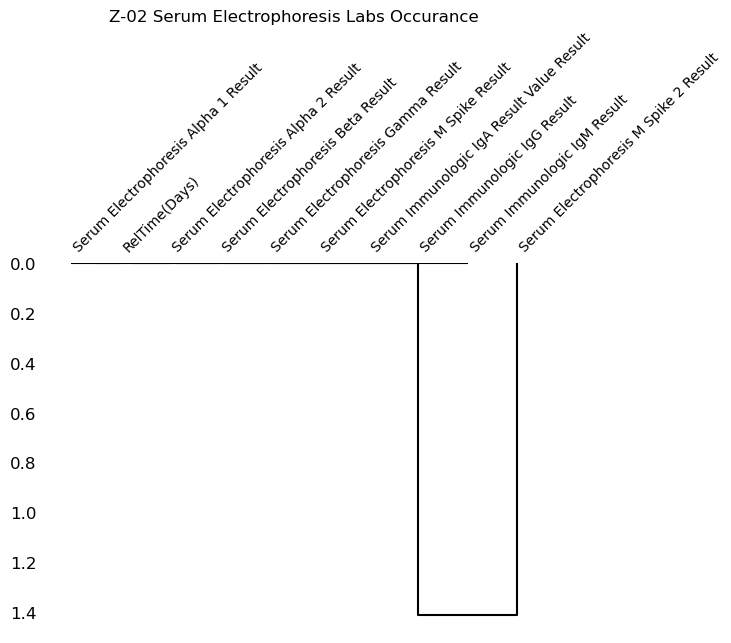

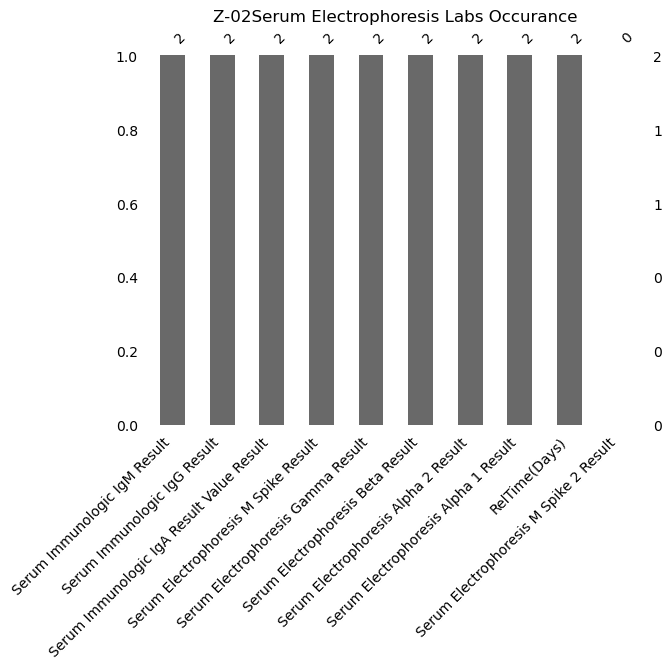

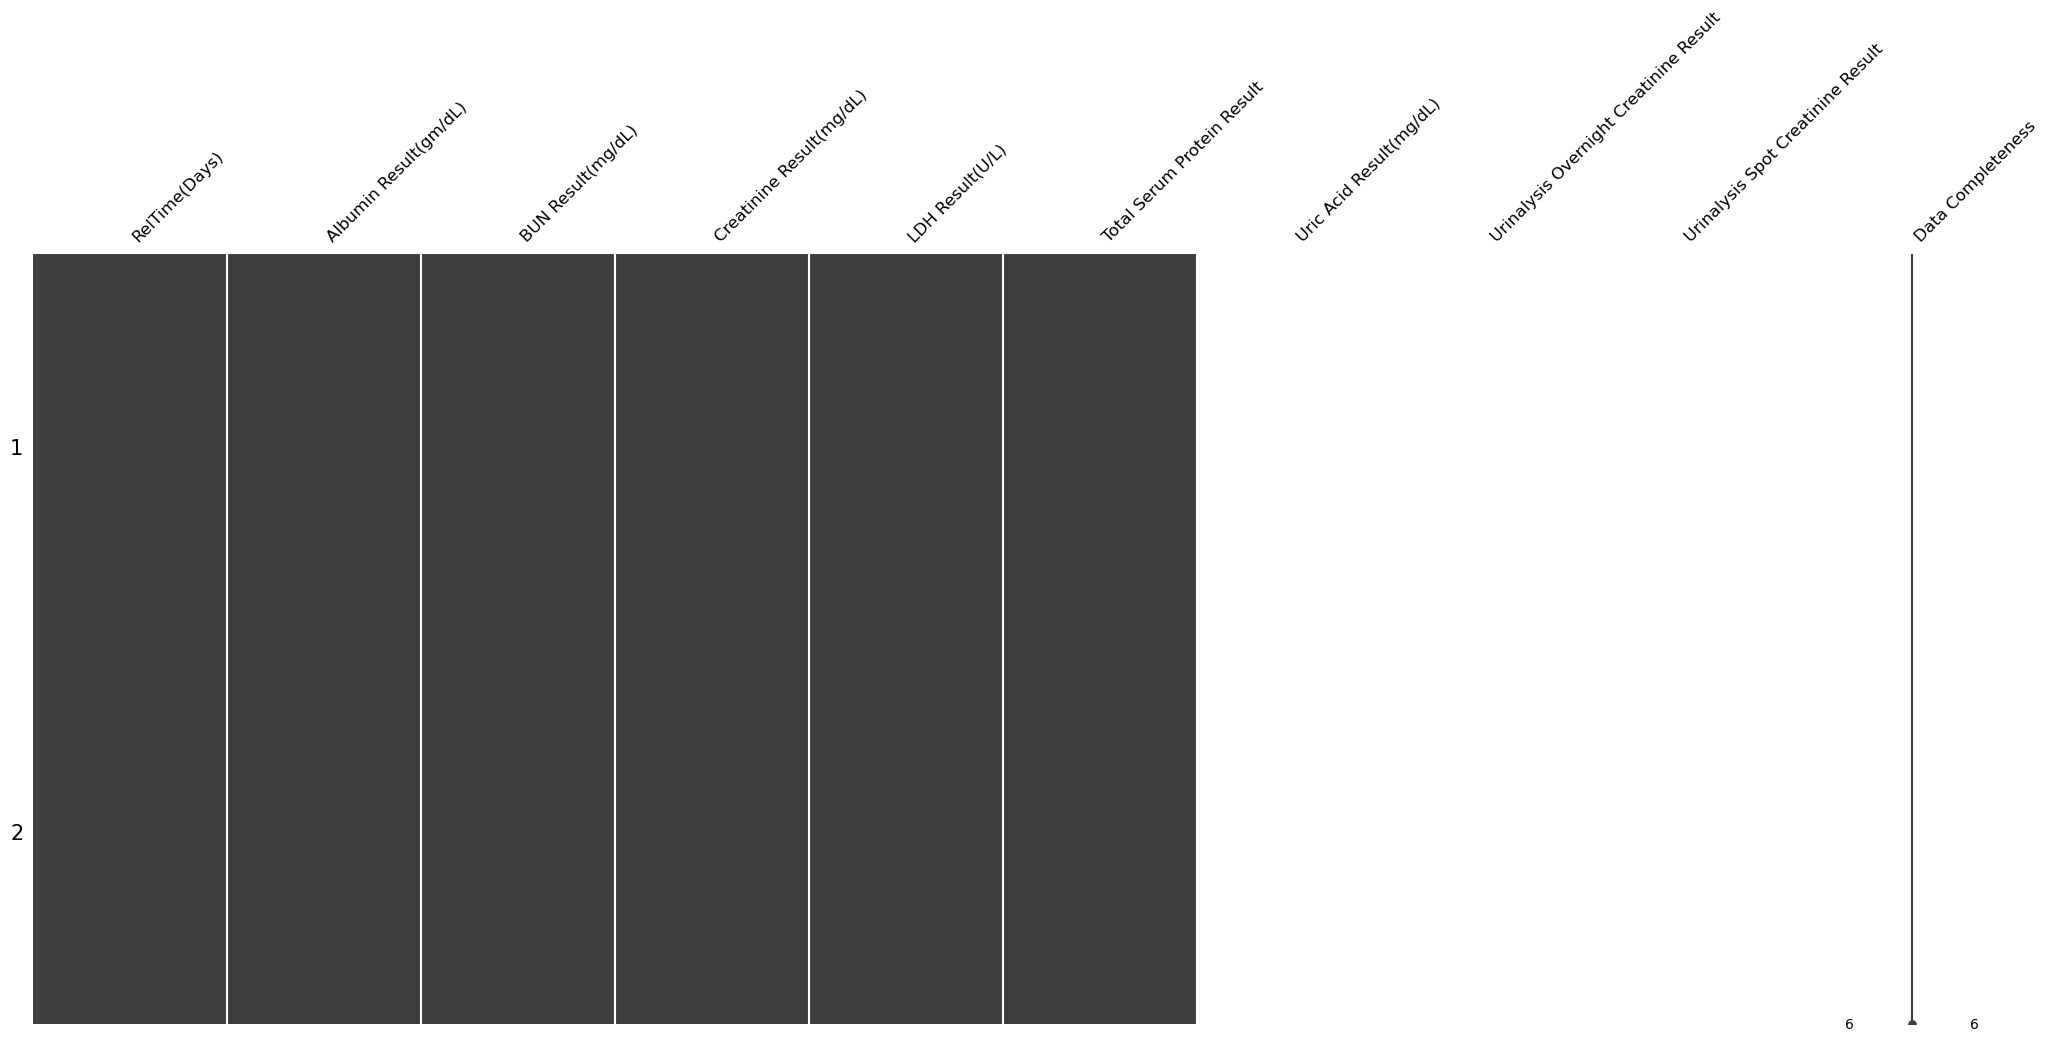

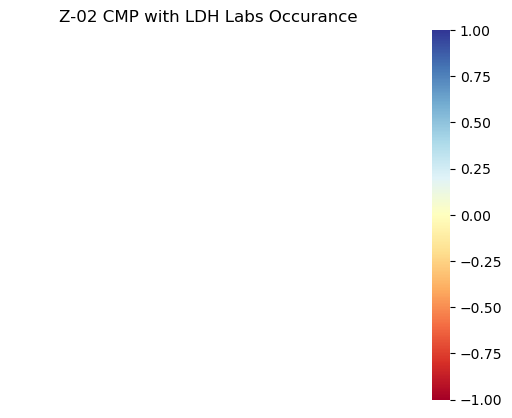

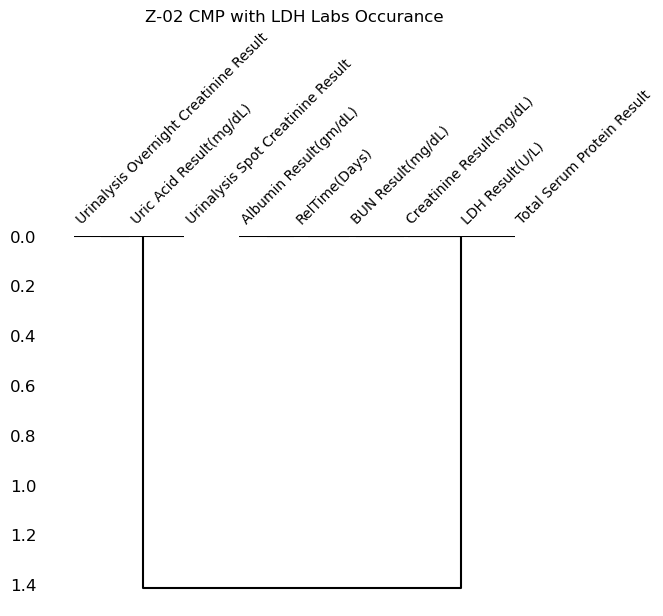

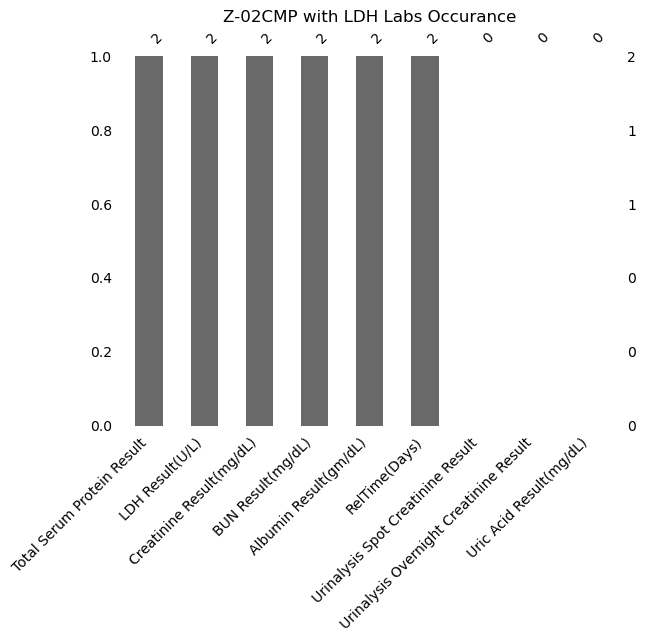

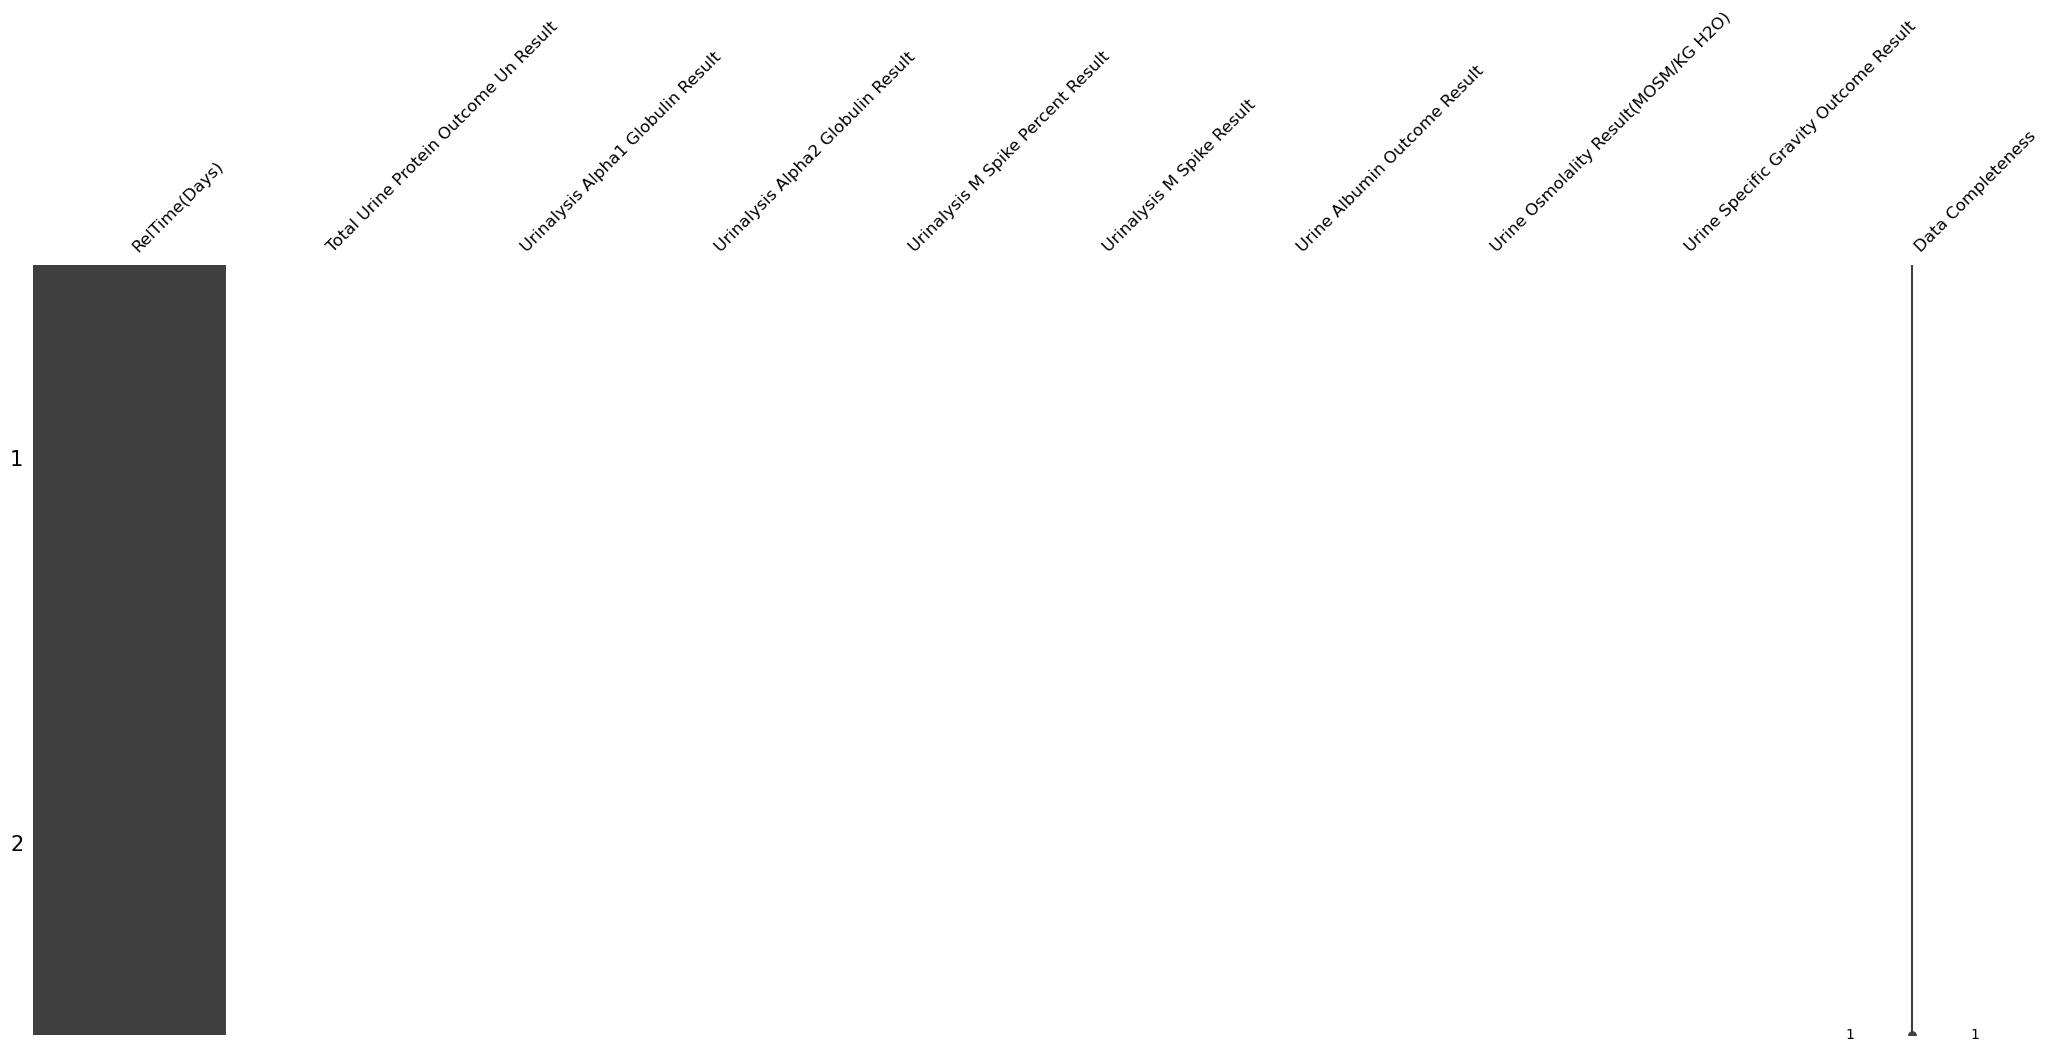

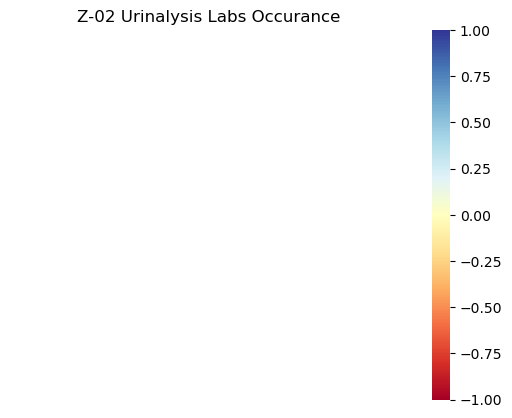

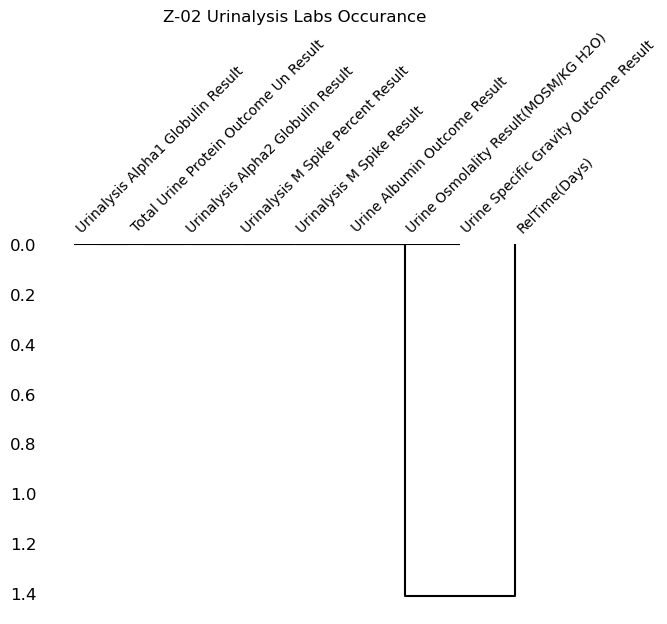

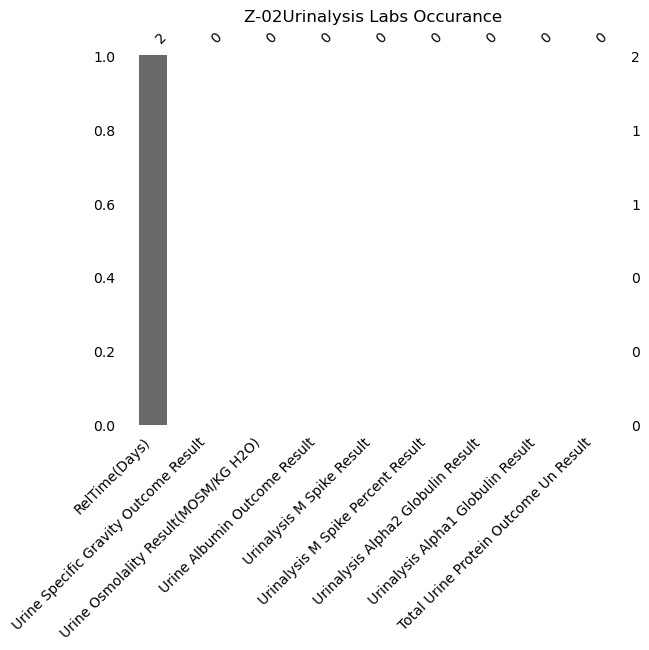

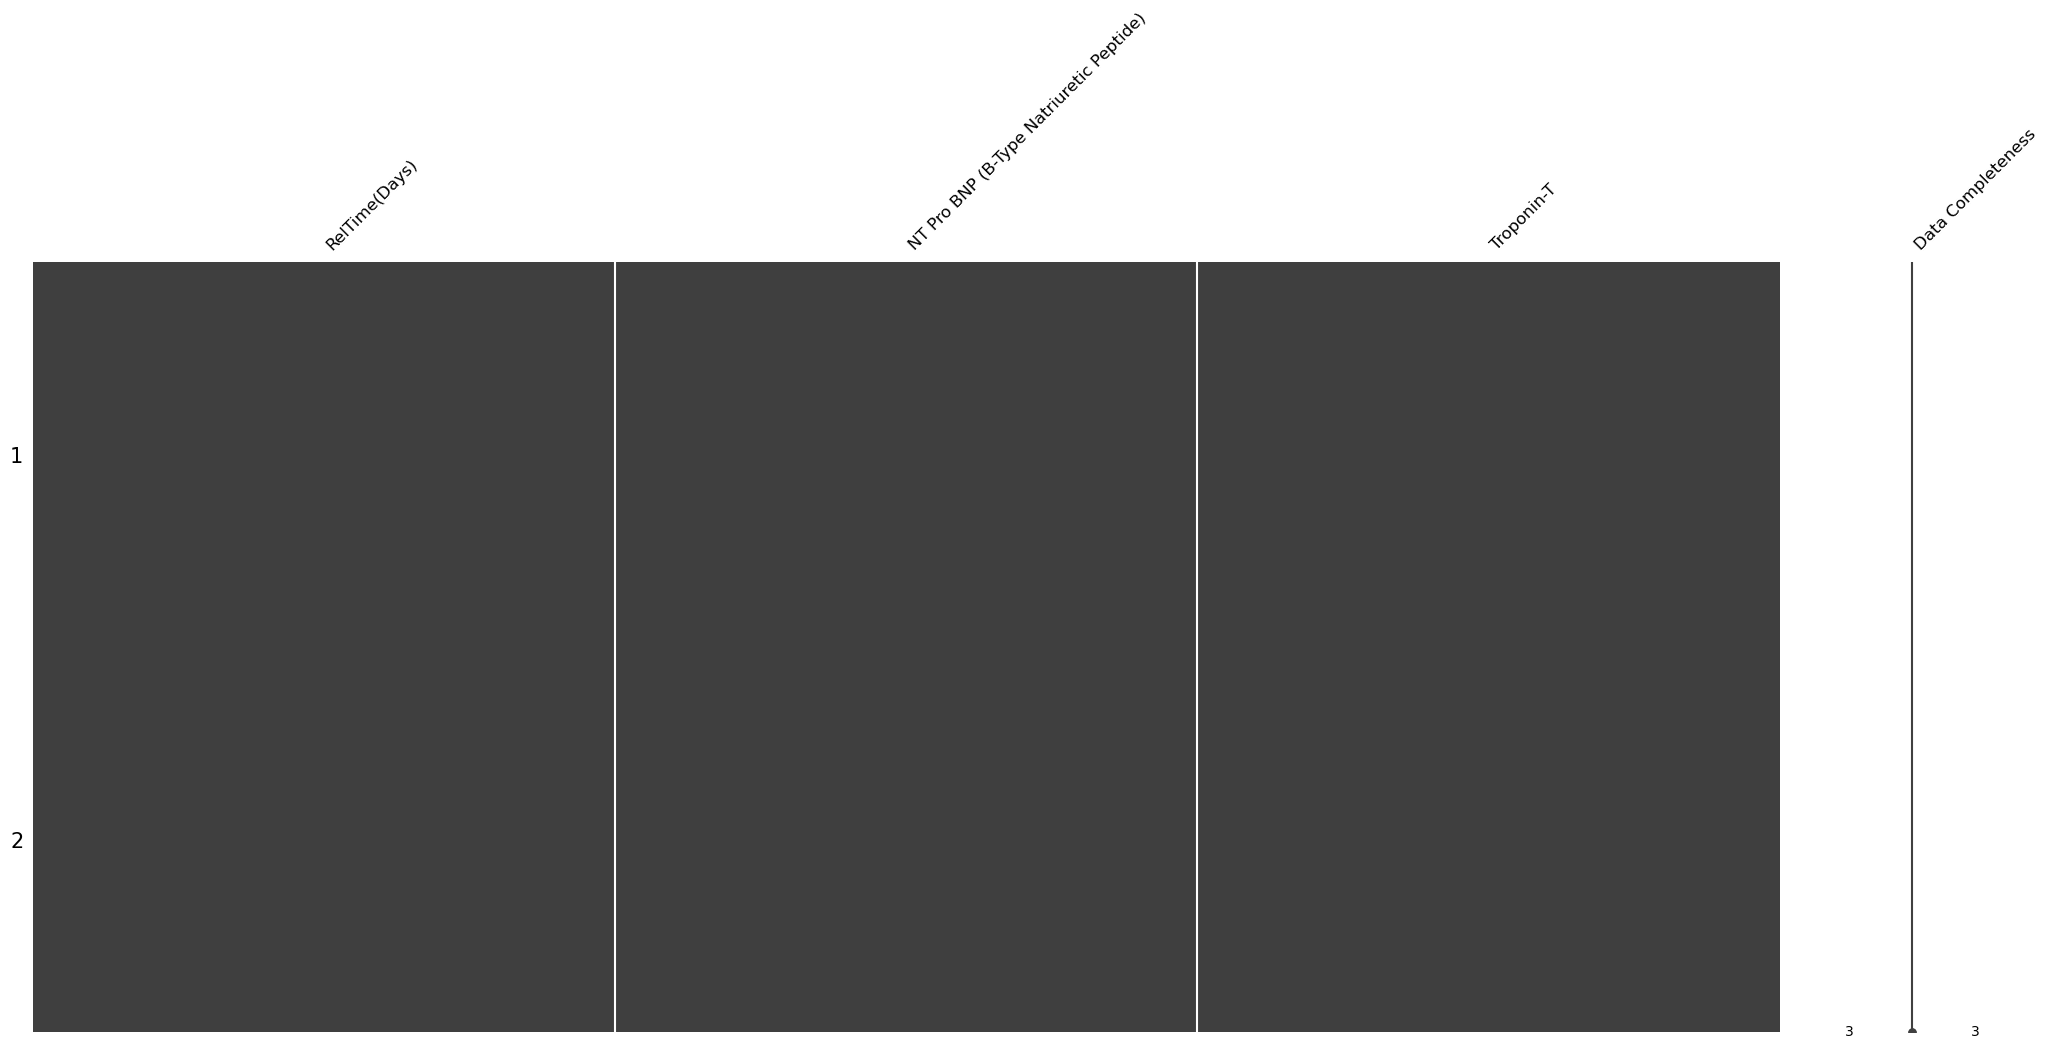

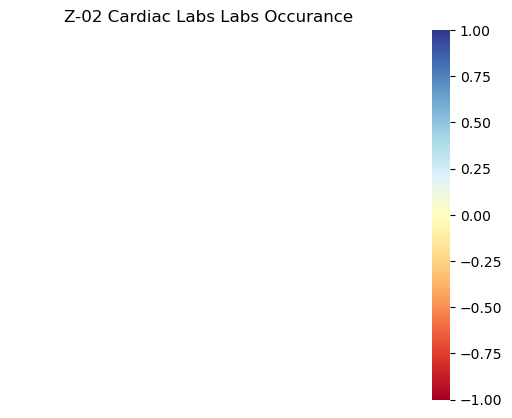

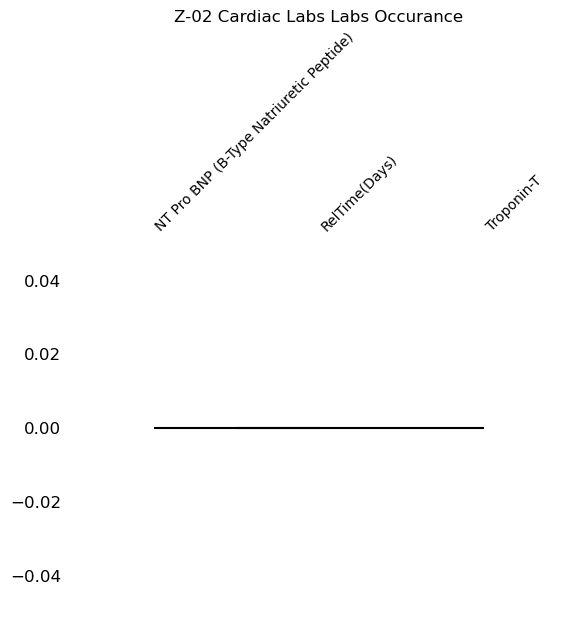

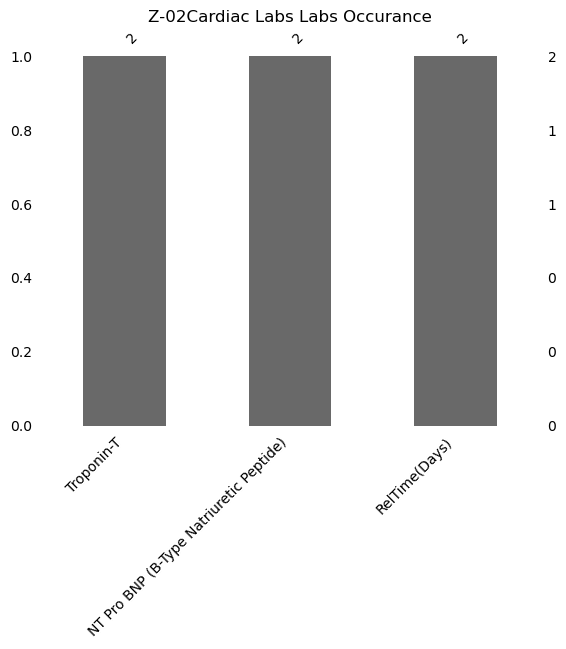

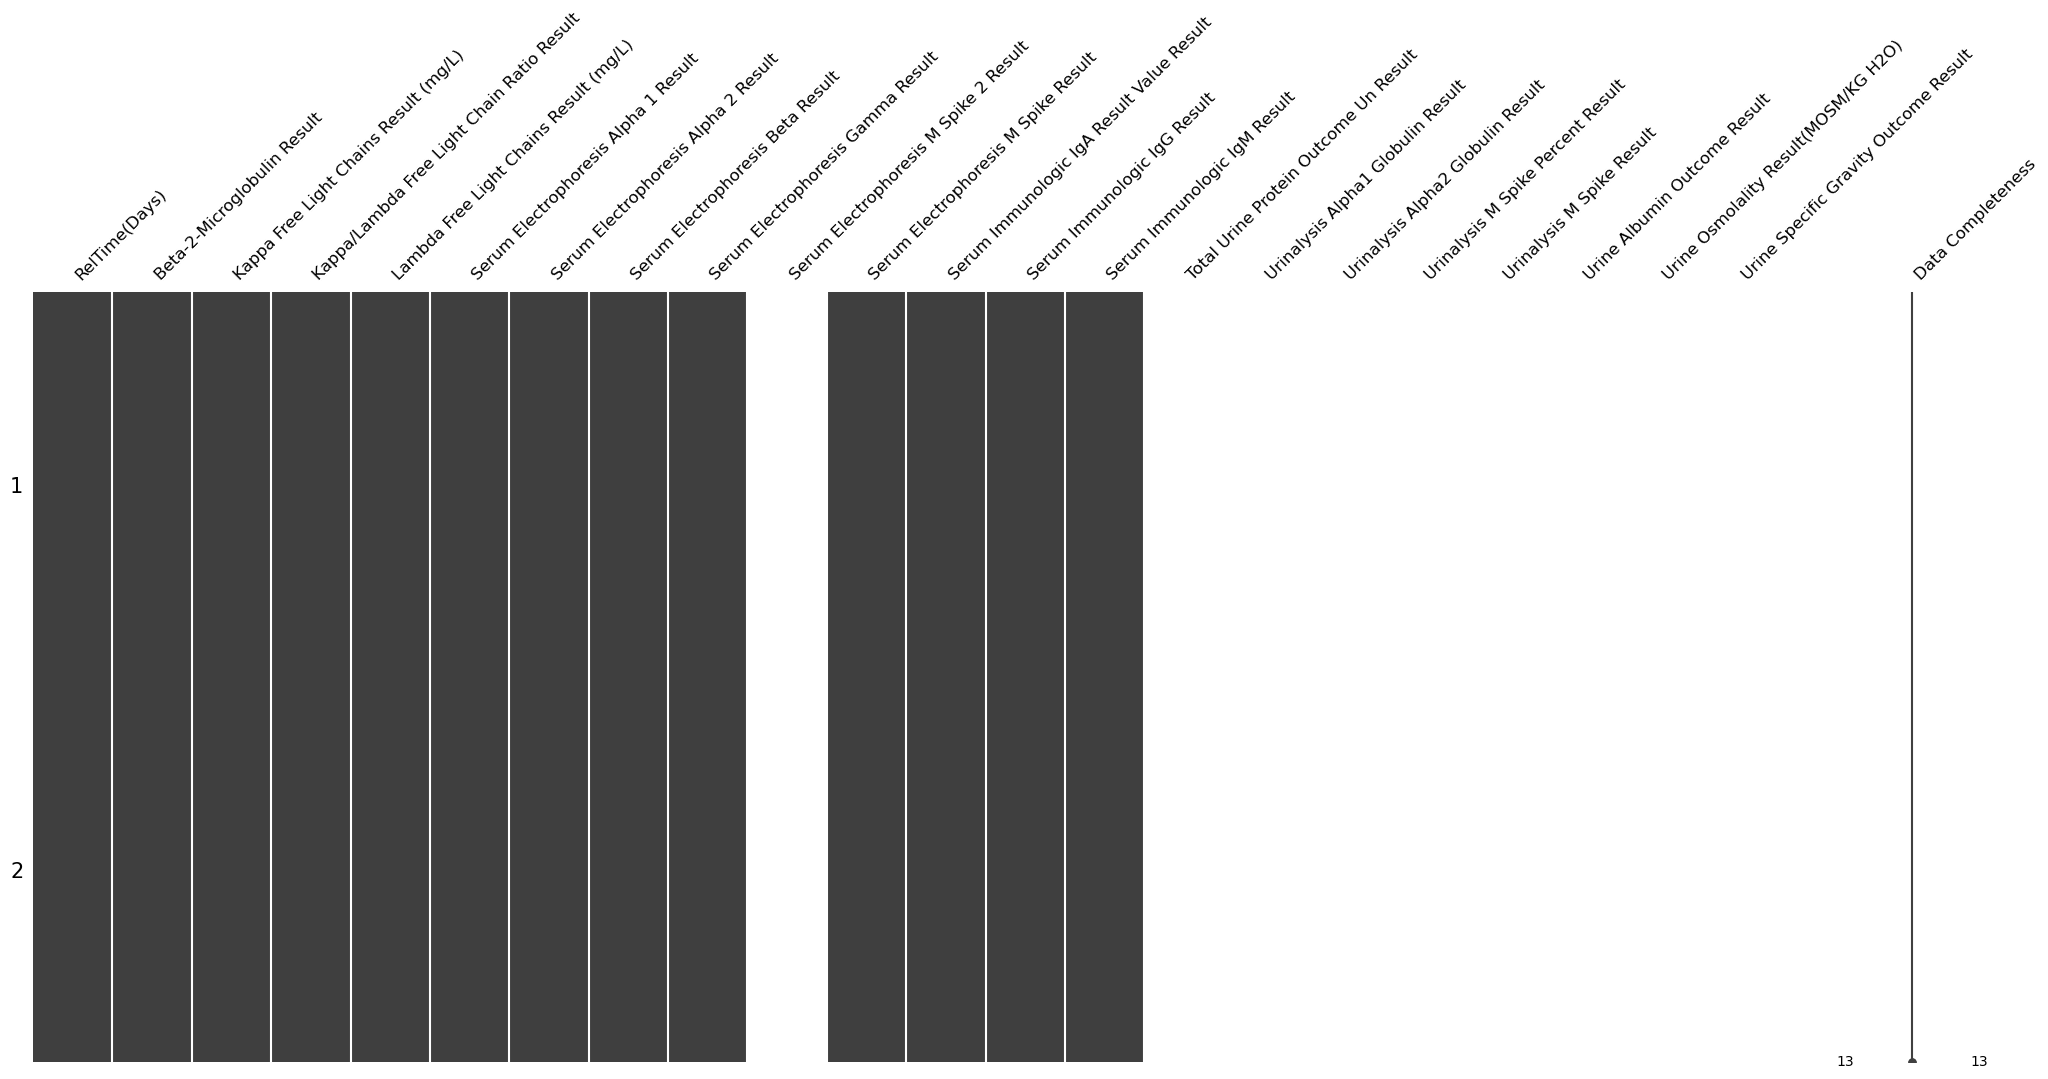

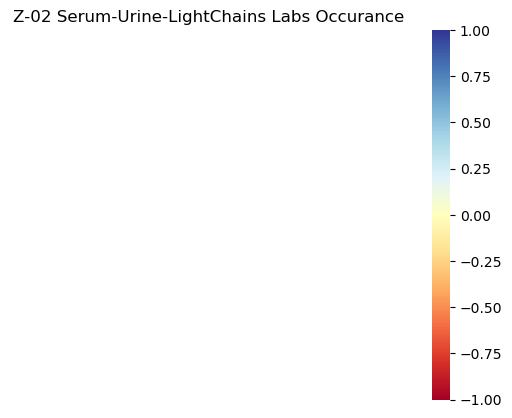

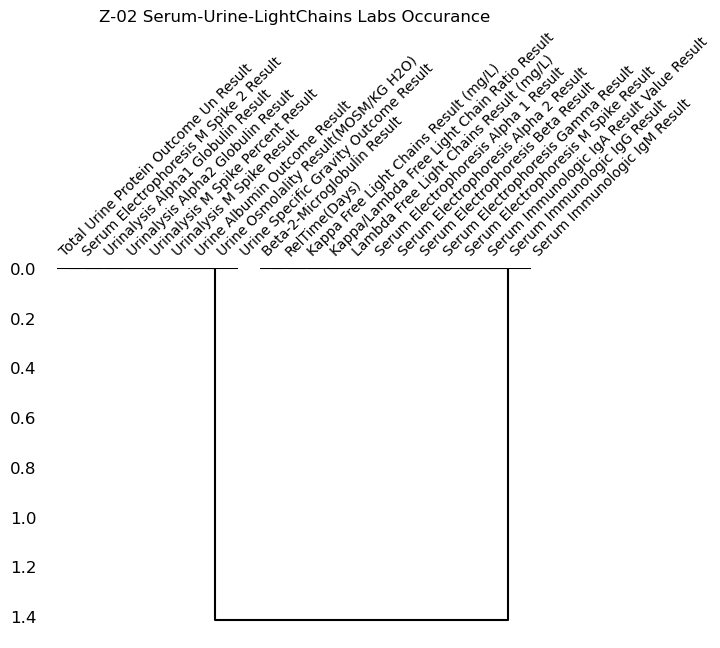

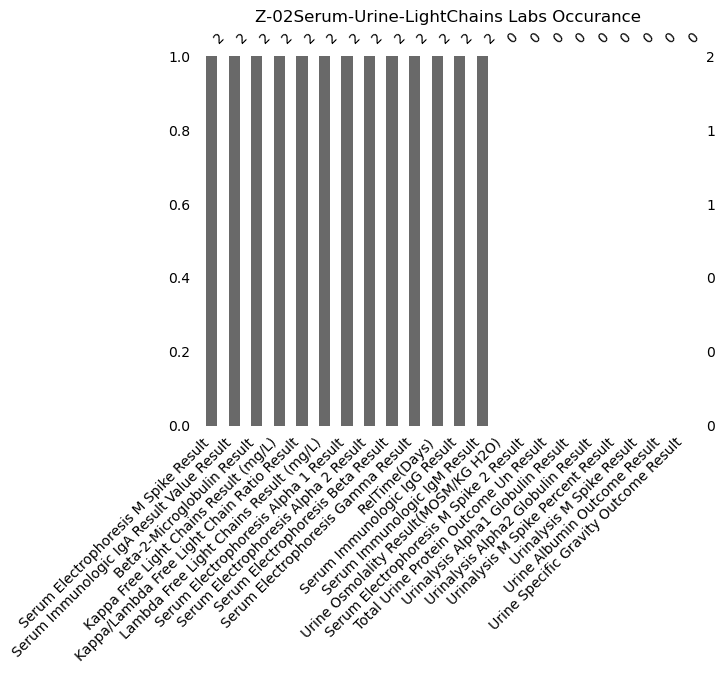

In [19]:
#single patient
ptID_test = "Z-02"
#make dirrectory for saving files 
parent_dir = new_dirrectory
folderName = ptID_test + "-labsOccurence"
path = os.path.join(parent_dir,folderName)
os.mkdir(path)

ptLabsTest = patientDictLabs[ptID_test]
#filtering patient lab columns to exclude columns which aren't results 
orig_columns = list(ptLabsTest.columns)

#to get all key words in one list
#combine list 1 and list 2
columnNames = FilterList(orig_columns, keyWords_primary = keywords_Primary, keyWords_secondary=['Result'], omit = ['Method','Nucleated RBC/100 WBC Result Method'])

keywords_Primary_2 = ["Troponin-T", "BNP", ]
columnNames2 = FilterList(orig_columns, keyWords_primary = keywords_Primary_2)

testNames = ["RelTime(Days)"]
testNames.extend(columnNames)
testNames.extend(columnNames2)

#new dataframe for plotting only results for all key words
ptLabsTest_results =  ptLabsTest[testNames]

msno.matrix(ptLabsTest_results, labels = True, fontsize= 12)
# ax.set_title(ptID_test, " Labs Occurance")
#saving files 
out_filename = ptID_test + '-' + 'LabsOccurance-matrixChart.tif'
new_filepath = os.path.join(path,out_filename)
plt.savefig(new_filepath, bbox_inches = 'tight')
# plt.close()

fig, ax_2 = plt.subplots(figsize= (20,15))
msno.heatmap(ptLabsTest_results, sort = "descending", figsize= (20,15), fontsize=10, cmap = 'RdYlBu', labels= False, ax= ax_2)
ax_2.set_title(ptID_test + " Labs Occurance")
out_filename = ptID_test + '-' + 'LabsOccurance-heatmap.tif'
new_filepath = os.path.join(path,out_filename)
plt.savefig(new_filepath, bbox_inches = 'tight')

fig, ax_3 = plt.subplots(figsize= (10,15))
msno.dendrogram(ptLabsTest_results, figsize= (10,15), fontsize= 10, ax= ax_3)
ax_3.set_title(ptID_test + " Labs Occurance")
out_filename = ptID_test + '-' + 'LabsOccurance-dendrogram.tif'
new_filepath = os.path.join(path,out_filename)
plt.savefig(new_filepath, bbox_inches = 'tight')

fig, ax_4= plt.subplots(figsize = (15, 8))
msno.bar(ptLabsTest_results, labels=True, fontsize= 10, sort= "descending", ax = ax_4)
ax_4.set_title(ptID_test + " Labs Occurance")
out_filename = ptID_test + '-' + 'LabsOccurance-bar.tif'
new_filepath = os.path.join(path,out_filename)
plt.savefig(new_filepath, bbox_inches = 'tight')


#filtering patient labs by group using dictionary
if len(ptLabsTest["RelTime(Days)"]) > 1:
    for set in ordersets_dict.keys():
        columnNames_sub = FilterList(orig_columns, keyWords_primary= ordersets_dict[set],
                                    keyWords_secondary= ordersets_secondary[set], omit= ordersets_omit[set])
        testNames_sub = ["RelTime(Days)"]
        testNames_sub.extend(columnNames_sub)
        ptLabsTest_orderset = ptLabsTest[testNames_sub]

        #potting the completeness of the data
        msno.matrix(ptLabsTest_orderset, labels = True, fontsize= 12)
    
        #saving files 
        out_filename = ptID_test + '-' + set + '-occurance-matrixChart.tif'
        new_filepath = os.path.join(path,out_filename)
        plt.savefig(new_filepath, bbox_inches = 'tight')

        fig, ax_2 = plt.subplots()
        msno.heatmap(ptLabsTest_orderset, sort = "descending", fontsize=10, cmap = 'RdYlBu', labels= False, ax= ax_2)
        ax_2.set_title(ptID_test + " " + set + " Labs Occurance")
        out_filename = ptID_test + '-' + set +'-occurance-heatmap.tif' 
        new_filepath = os.path.join(path,out_filename)
        plt.savefig(new_filepath, bbox_inches = 'tight')
 

        fig, ax_3 = plt.subplots()
        msno.dendrogram(ptLabsTest_orderset, fontsize= 10, ax= ax_3)
        ax_3.set_title(ptID_test + " "+ set + " Labs Occurance")
        out_filename = ptID_test + '-' + set + '-occurance-dendrogram.tif'
        new_filepath = os.path.join(path,out_filename)
        plt.savefig(new_filepath, bbox_inches = 'tight')

        fig, ax_4= plt.subplots()
        msno.bar(ptLabsTest_orderset, labels=True, fontsize= 10, sort= "descending", ax = ax_4)
        ax_4.set_title(ptID_test + "" + set + " Labs Occurance")
        out_filename = ptID_test + '-' + set + '-occurance-bar.tif'
        new_filepath = os.path.join(path,out_filename)
        plt.savefig(new_filepath, bbox_inches = 'tight')

c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
c:\Users\maega\anaconda3\envs\BEAT-Labs\lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\maega\\Documents\\3000 PhD\\3300_BEAT Labs\\Projects\\Cardiac-Amyloidosis-Multiple-Myeloma\\012 Processed Data\\data-2024-06-05\\Z-02-labsOccurence\\Z-02-Serum-Urine-LightChains-occurance-dendrogram.tif'

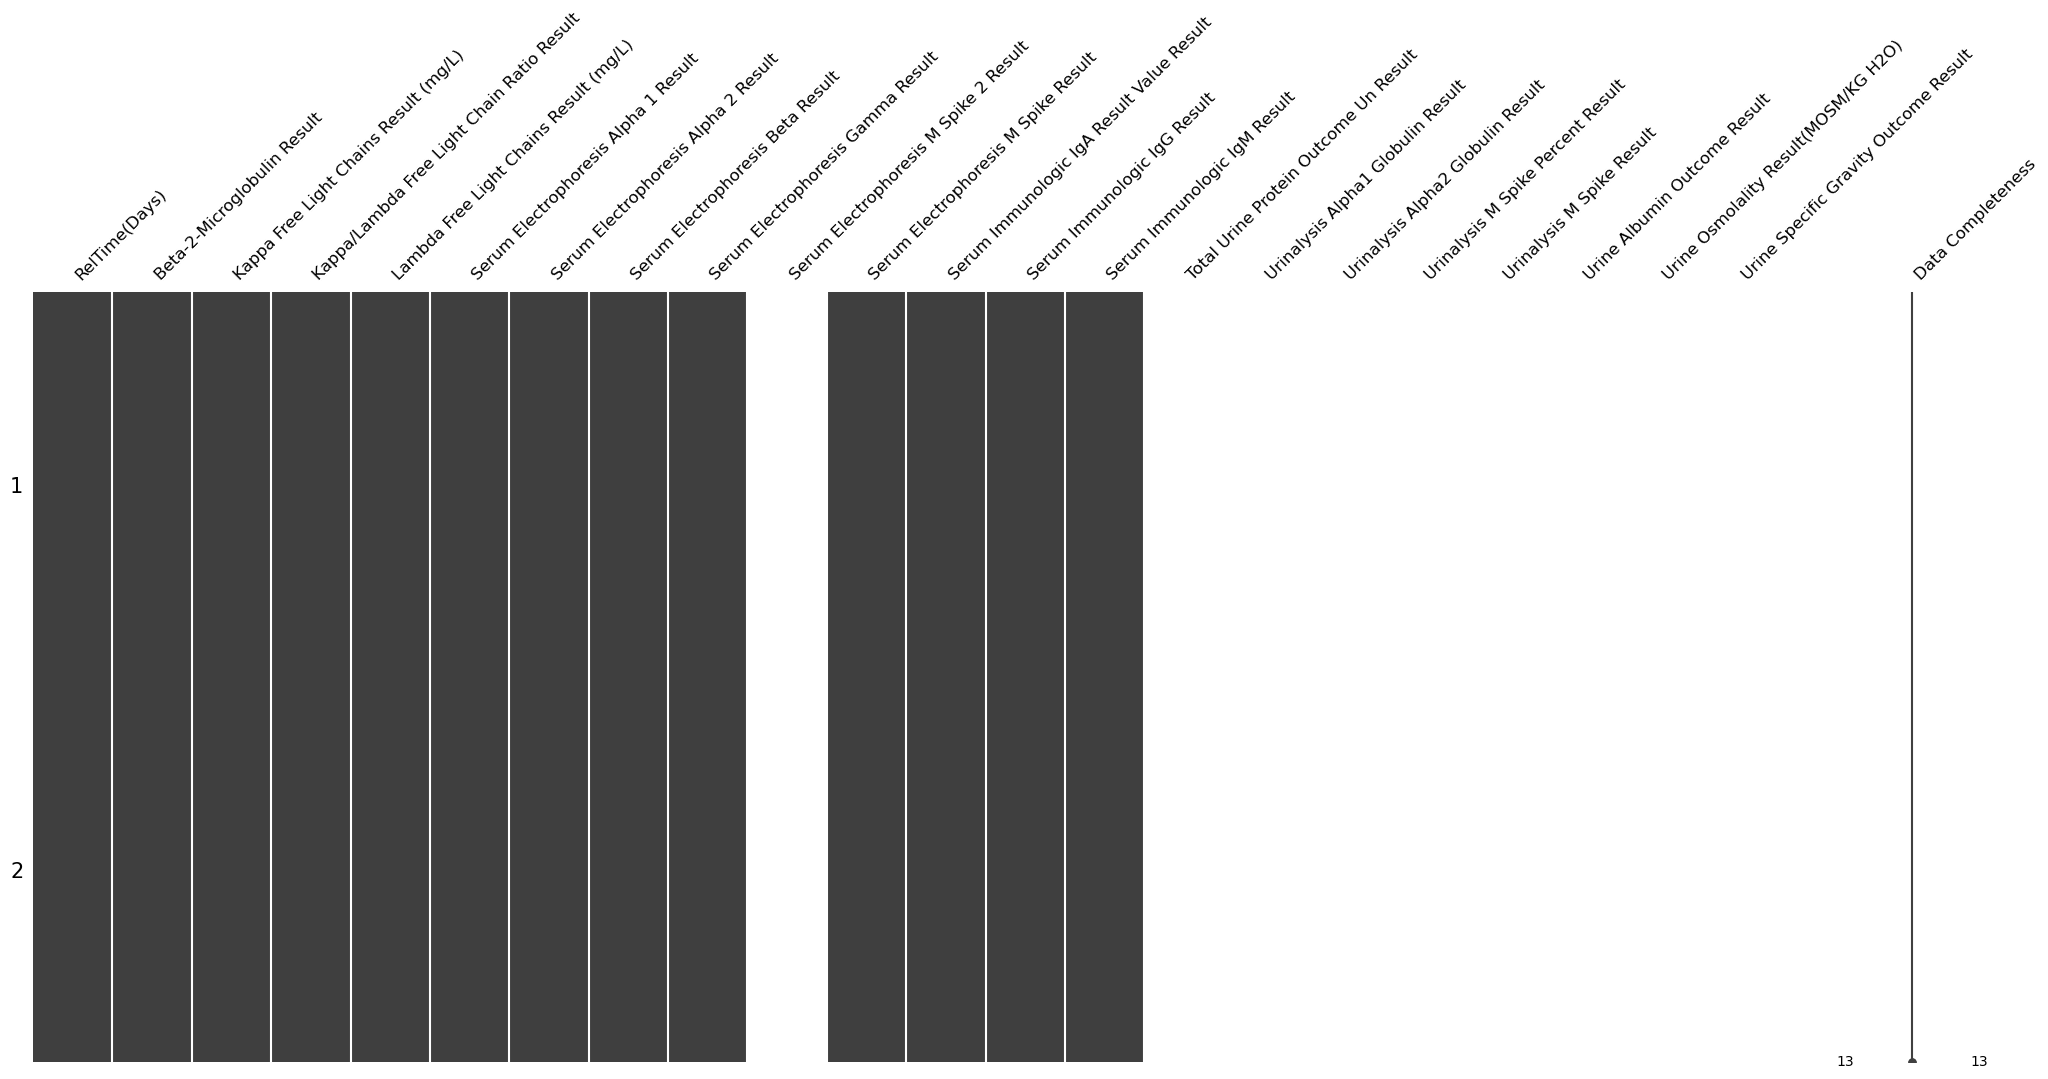

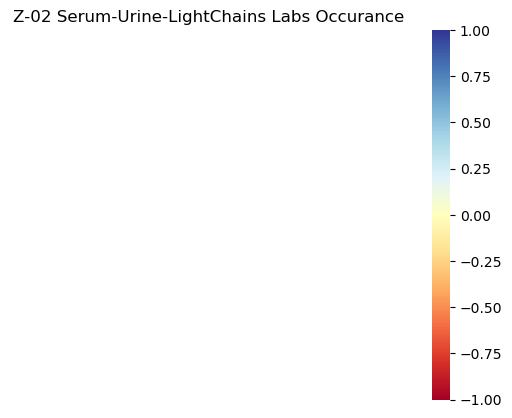

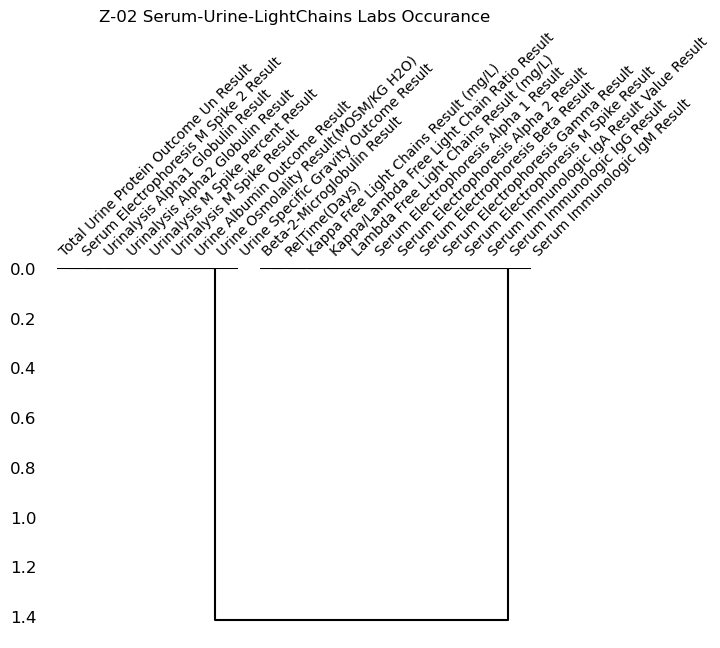

In [18]:
for pt in patientDictLabs.keys():
    ptID_test = pt

    #make dirrectory for saving files 
    parent_dir = new_dirrectory
    folderName = ptID_test + "-labsOccurence"
    path = os.path.join(parent_dir,folderName)
    os.mkdir(path)

    ptLabsTest = patientDictLabs[ptID_test]
    #filtering patient lab columns to exclude columns which aren't results 
    orig_columns = list(ptLabsTest.columns)

    #to get all key words in one list
    #combine list 1 and list 2
    columnNames = FilterList(orig_columns, keyWords_primary = keywords_Primary, keyWords_secondary=['Result'], omit = ['Method','Nucleated RBC/100 WBC Result Method'])

    keywords_Primary_2 = ["Troponin-T", "BNP", ]
    columnNames2 = FilterList(orig_columns, keyWords_primary = keywords_Primary_2)

    testNames = ["RelTime(Days)"]
    testNames.extend(columnNames)
    testNames.extend(columnNames2)

    #new dataframe for plotting only results for all key words
    ptLabsTest_results =  ptLabsTest[testNames]

    msno.matrix(ptLabsTest_results, labels = True, fontsize= 12)
    # ax.set_title(ptID_test, " Labs Occurance")
    #saving files 
    out_filename = ptID_test + '-' + 'LabsOccurance-matrixChart.tif'
    new_filepath = os.path.join(path,out_filename)
    plt.savefig(new_filepath, bbox_inches = 'tight')
    # plt.close()

    fig, ax_2 = plt.subplots(figsize= (20,15))
    msno.heatmap(ptLabsTest_results, sort = "descending", figsize= (20,15), fontsize=10, cmap = 'RdYlBu', labels= False, ax= ax_2)
    ax_2.set_title(ptID_test + " Labs Occurance")
    out_filename = ptID_test + '-' + 'LabsOccurance-heatmap.tif'
    new_filepath = os.path.join(path,out_filename)
    plt.savefig(new_filepath, bbox_inches = 'tight')

    fig, ax_3 = plt.subplots(figsize= (10,15))
    msno.dendrogram(ptLabsTest_results, figsize= (10,15), fontsize= 10, ax= ax_3)
    ax_3.set_title(ptID_test + " Labs Occurance")
    out_filename = ptID_test + '-' + 'LabsOccurance-dendrogram.tif'
    new_filepath = os.path.join(path,out_filename)
    plt.savefig(new_filepath, bbox_inches = 'tight')

    fig, ax_4= plt.subplots(figsize = (15, 8))
    msno.bar(ptLabsTest_results, labels=True, fontsize= 10, sort= "descending", ax = ax_4)
    ax_4.set_title(ptID_test + " Labs Occurance")
    out_filename = ptID_test + '-' + 'LabsOccurance-bar.tif'
    new_filepath = os.path.join(path,out_filename)
    plt.savefig(new_filepath, bbox_inches = 'tight')


    #filtering patient labs by group using dictionary
    if len(ptLabsTest["RelTime(Days)"]) > 1:
        for set in ordersets_dict.keys():
            columnNames_sub = FilterList(orig_columns, keyWords_primary= ordersets_dict[set],
                                        keyWords_secondary= ordersets_secondary[set], omit= ordersets_omit[set])
            testNames_sub = ["RelTime(Days)"]
            testNames_sub.extend(columnNames_sub)
            ptLabsTest_orderset = ptLabsTest[testNames_sub]

            #potting the completeness of the data
            msno.matrix(ptLabsTest_orderset, labels = True, fontsize= 12)
        
            #saving files 
            out_filename = ptID_test + '-' + set + '-occurance-matrixChart.tif'
            new_filepath = os.path.join(path,out_filename)
            plt.savefig(new_filepath, bbox_inches = 'tight')

            fig, ax_2 = plt.subplots()
            msno.heatmap(ptLabsTest_orderset, sort = "descending", fontsize=10, cmap = 'RdYlBu', labels= False, ax= ax_2)
            ax_2.set_title(ptID_test + " " + set + " Labs Occurance")
            out_filename = ptID_test + '-' + set +'-occurance-heatmap.tif' 
            new_filepath = os.path.join(path,out_filename)
            plt.savefig(new_filepath, bbox_inches = 'tight')
    

            fig, ax_3 = plt.subplots()
            msno.dendrogram(ptLabsTest_orderset, fontsize= 10, ax= ax_3)
            ax_3.set_title(ptID_test + " "+ set + " Labs Occurance")
            out_filename = ptID_test + '-' + set + '-occurance-dendrogram.tif'
            new_filepath = os.path.join(path,out_filename)
            plt.savefig(new_filepath, bbox_inches = 'tight')

            fig, ax_4= plt.subplots()
            msno.bar(ptLabsTest_orderset, labels=True, fontsize= 10, sort= "descending", ax = ax_4)
            ax_4.set_title(ptID_test + "" + set + " Labs Occurance")
            out_filename = ptID_test + '-' + set + '-occurance-bar.tif'
            new_filepath = os.path.join(path,out_filename)
            plt.savefig(new_filepath, bbox_inches = 'tight')

            plt.close('all')
    plt.close('all')

for looking at patient labs clustered by amyloid status

In [ ]:
#get amyloid status dictionary inputs, sort ptIDs to lists based on amyloid status 
def getListSortedByAmyloid(amyloidDictionary, listPositive, listNegative, listOther,
                           statusPositive = "yes", statusNegative = "no"):
    for pt in amyloidDictionary.keys():
        status = amyloidDictionary[pt]
        if status == statusPositive:
            listPositive.append(pt)
        elif status == statusNegative:
            listNegative.append(pt)
        else:
            listOther.append(pt)
    #does not check for double listed patient IDs
#use this list to help pick patient IDs for plotting

#testing this function
listPositive = []
listNegative = []
listOther = []
getListSortedByAmyloid(patientDictAmyloid, listPositive= listPositive, listNegative= listNegative,
                       listOther=listOther)

for examining the completeness of the overall information across all patients\
first looks at echo completeness of data\
second looks at overall labs across all patients\
lastely, looking into the ordersets across all patients\

In [ ]:
#looking at echo data
ptID_test = "all pts"

ptLabsTest = pd.read_excel("C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/010 Raw Data/amyloid patients by IR w all manaul adjusts_deID_2020-12-20.xlsx", sheet_name= "amyloid in subject")

#filtering patient lab columns to exclude columns which aren't results 
orig_columns = list(ptLabsTest.columns)

#to get all key words in one list
#combine list 1 and list 2
columnNames = FilterList(orig_columns, keyWords_primary = ["1st", "fin", "MRI"])

testNames = ["time from diagnosis to first echo (months)"]
testNames.extend(columnNames)

#new dataframe for plotting only results for all key words
ptLabsTest_results =  ptLabsTest[testNames]

msno.matrix(ptLabsTest_results, labels = True, fontsize= 12)
# ax.set_title(ptID_test, " Labs Occurance")
#saving files 
out_filename = ptID_test + '-' + 'Echo-matrixChart.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_2 = plt.subplots(figsize=(12,10))
msno.heatmap(ptLabsTest_results, sort = "descending", figsize=(12,10), fontsize=10, cmap = 'RdYlBu', labels= False, ax= ax_2)
ax_2.set_title(ptID_test + " Echo")
out_filename = ptID_test + '-' + 'Echo-heatmap.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_3 = plt.subplots(figsize=(10,10))
msno.dendrogram(ptLabsTest_results, figsize=(10,10), fontsize= 10, ax= ax_3)
ax_3.set_title(ptID_test + " Echo")
out_filename = ptID_test + '-' + 'Echo-dendrogram.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_4= plt.subplots(figsize=(15,8))
msno.bar(ptLabsTest_results, figsize=(15,8), labels=True, fontsize= 10, sort= "descending", ax = ax_4)
ax_4.set_title(ptID_test + " Echo")
out_filename = ptID_test + '-' + 'Echo-bar.tif'
plt.savefig(out_filename, bbox_inches = 'tight')



In [10]:
#looking at labs data across all patients
ptID_test = "All Patients"
# "C:\Users\maega\Documents\3000 PhD\3300_BEAT Labs\Projects\Cardiac-Amyloidosis-Multiple-Myeloma\010 Raw Data\LIMS#10R19000024_outfile-by-IR+MCF_deID_2020-12-17.xlsx"
ptLabsTest = pd.read_excel("C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/010 Raw Data/LIMS#10R19000024_outfile-by-IR+MCF_deID_2020-12-17.xlsx", sheet_name= "Labs")
pt = "All Patients"
#filtering patient lab columns to exclude columns which aren't results 
orig_columns = list(ptLabsTest.columns)

#to get all key words in one list
#combine list 1 and list 2
columnNames = FilterList(orig_columns, keyWords_primary = keywords_Primary, keyWords_secondary=['Result'], omit = ['Method','Nucleated RBC/100 WBC Result Method'])

keywords_Primary_2 = ["Troponin-T", "BNP", ]
columnNames2 = FilterList(orig_columns, keyWords_primary = keywords_Primary_2)

testNames = ["RelTime(Days)"]
testNames.extend(columnNames)
testNames.extend(columnNames2)

#new dataframe for plotting only results for all key words
ptLabsTest_results =  ptLabsTest[testNames]

msno.matrix(ptLabsTest_results, labels = True, fontsize= 12)
# ax.set_title(ptID_test, " Labs Occurance")
#saving files 
out_filename = ptID_test + '-' + 'LabsOccurance-matrixChart.tif'
plt.savefig(out_filename, bbox_inches = 'tight')
plt.close()

fig, ax_2 = plt.subplots(figsize= (20,15))
msno.heatmap(ptLabsTest_results, sort = "descending", figsize= (20,15), fontsize=10, cmap = 'RdYlBu', labels= False, ax= ax_2)
ax_2.set_title(ptID_test + " Labs Occurance")
out_filename = ptID_test + '-' + 'LabsOccurance-heatmap.tif'
plt.savefig(out_filename, bbox_inches = 'tight')
plt.close()

fig, ax_3 = plt.subplots(figsize= (10,15))
msno.dendrogram(ptLabsTest_results, figsize= (10,15), fontsize= 10, ax= ax_3)
ax_3.set_title(ptID_test + " Labs Occurance")
out_filename = ptID_test + '-' + 'LabsOccurance-dendrogram.tif'
plt.savefig(out_filename, bbox_inches = 'tight')
plt.close()

fig, ax_4= plt.subplots(figsize = (15, 8))
msno.bar(ptLabsTest_results, labels=True, fontsize= 10, sort= "descending", ax = ax_4)
ax_4.set_title(ptID_test + " Labs Occurance")
out_filename = ptID_test + '-' + 'LabsOccurance-bar.tif'
plt.savefig(out_filename, bbox_inches = 'tight')
plt.close()


#filtering patient labs by group using dictionary
for set in ordersets_dict.keys():
    columnNames_sub = FilterList(orig_columns, keyWords_primary= ordersets_dict[set],
                                keyWords_secondary= ordersets_secondary[set], omit= ordersets_omit[set])
    testNames_sub = ["RelTime(Days)"]
    testNames_sub.extend(columnNames_sub)
    ptLabsTest_orderset = ptLabsTest[testNames_sub]

    #potting the completeness of the data
    msno.matrix(ptLabsTest_orderset, labels = True, fontsize= 12)
    # ax.set_title(ptID_test, " Labs Occurance")
    #saving files 
    out_filename = ptID_test + '-' + set + '-occurance-matrixChart.tif'
    plt.savefig(out_filename, bbox_inches = 'tight')
    plt.close()

    fig, ax_2 = plt.subplots()
    msno.heatmap(ptLabsTest_orderset, sort = "descending", fontsize=10, cmap = 'RdYlBu', labels= False, ax= ax_2)
    ax_2.set_title(ptID_test + " " + set + " Labs Occurance")
    out_filename = ptID_test + '-' + set +'-LabsOccurance-heatmap.tif'
    plt.savefig(out_filename, bbox_inches = 'tight')
    plt.close()
    #may need to clean the data for strings before plotting
    #is there a way to fetch values which print with high correlation?
    #look at the algorithm and see if you can access teh dataframe and filter it for the highest and lowest outputs
    fig, ax_3 = plt.subplots()
    msno.dendrogram(ptLabsTest_orderset, fontsize= 10, ax= ax_3)
    ax_3.set_title(ptID_test + " "+ set + " Labs Occurance")
    out_filename = ptID_test + '-' + set + '-LabsOccurance-dendrogram.tif'
    plt.savefig(out_filename, bbox_inches = 'tight')
    plt.close()

    fig, ax_4= plt.subplots()
    msno.bar(ptLabsTest_orderset, labels=True, fontsize= 10, sort= "descending", ax = ax_4)
    ax_4.set_title(ptID_test + "" + set + " Labs Occurance")
    out_filename = ptID_test + '-' + set + '-LabsOccurance-bar.tif'
    plt.savefig(out_filename, bbox_inches = 'tight')
    plt.close()

In [ ]:
#physician notes
ptID_test = "all pts"
sheetName = "Physician_Notes"
ptLabsTest = pd.read_excel("C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/010 Raw Data/LIMS#10R19000024_outfile-by-IR+MCF_deID_2020-12-17.xlsx", sheet_name= "Physican_Notes")

# ptLabsTest = pd.read_excel("C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/010 Raw Data/amyloid patients by IR w all manaul adjusts_deID_2020-12-20.xlsx", sheet_name= "Physican_Notes")


#filtering patient lab columns to exclude columns which aren't results 
orig_columns = list(ptLabsTest.columns)

#to get all key words in one list
#combine list 1 and list 2
columnNames = FilterList(orig_columns, keyWords_primary = ["1st", "fin", "MRI"])

#new dataframe for plotting only results for all key words
ptLabsTest_results =  ptLabsTest[orig_columns]

msno.matrix(ptLabsTest_results, labels = True, fontsize= 12)
# ax.set_title(ptID_test, " Labs Occurance")
#saving files 
out_filename = ptID_test + '-' + sheetName + '-matrixChart.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_2 = plt.subplots(figsize=(12,10))
msno.heatmap(ptLabsTest_results, sort = "descending", figsize=(12,10), fontsize=10, cmap = 'RdYlBu', labels= False, ax= ax_2)
ax_2.set_title(ptID_test + " " + sheetName)
out_filename = ptID_test + '-' + sheetName+ '-heatmap.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_3 = plt.subplots(figsize=(10,10))
msno.dendrogram(ptLabsTest_results, figsize=(10,10), fontsize= 10, ax= ax_3)
ax_3.set_title(ptID_test + " " + sheetName)
out_filename = ptID_test + '-' + sheetName + '-dendrogram.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_4= plt.subplots(figsize=(15,8))
msno.bar(ptLabsTest_results, figsize=(15,8), labels=True, fontsize= 10, sort= "descending", ax = ax_4)
ax_4.set_title(ptID_test + " "+ sheetName)
out_filename = ptID_test + '-' + sheetName + '-bar.tif'
plt.savefig(out_filename, bbox_inches = 'tight')


In [ ]:
#chemotx
ptID_test = "all pts"
sheetName = "ChemoTx"
ptLabsTest = pd.read_excel("C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/010 Raw Data/LIMS#10R19000024_outfile-by-IR+MCF_deID_2020-12-17.xlsx", sheet_name= sheetName)


#filtering patient lab columns to exclude columns which aren't results 
orig_columns = list(ptLabsTest.columns)

#to get all key words in one list
#combine list 1 and list 2
columnNames = FilterList(orig_columns, keyWords_primary = ["1st", "fin", "MRI"])

#new dataframe for plotting only results for all key words
ptLabsTest_results =  ptLabsTest[orig_columns]

msno.matrix(ptLabsTest_results, labels = True, fontsize= 12)
# ax.set_title(ptID_test, " Labs Occurance")
#saving files 
out_filename = ptID_test + '-' + sheetName + '-matrixChart.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_2 = plt.subplots(figsize=(12,10))
msno.heatmap(ptLabsTest_results, sort = "descending", figsize=(12,10), fontsize=10, cmap = 'RdYlBu', labels= False, ax= ax_2)
ax_2.set_title(ptID_test + " " + sheetName)
out_filename = ptID_test + '-' + sheetName+ '-heatmap.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_3 = plt.subplots(figsize=(10,10))
msno.dendrogram(ptLabsTest_results, figsize=(10,10), fontsize= 10, ax= ax_3)
ax_3.set_title(ptID_test + " " + sheetName)
out_filename = ptID_test + '-' + sheetName + '-dendrogram.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_4= plt.subplots(figsize=(15,8))
msno.bar(ptLabsTest_results, figsize=(15,8), labels=True, fontsize= 10, sort= "descending", ax = ax_4)
ax_4.set_title(ptID_test + " "+ sheetName)
out_filename = ptID_test + '-' + sheetName + '-bar.tif'
plt.savefig(out_filename, bbox_inches = 'tight')


In [ ]:
#Hematologic Tx
ptID_test = "all pts"
sheetName = "Hematologic Tx"
ptLabsTest = pd.read_excel("C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/010 Raw Data/LIMS#10R19000024_outfile-by-IR+MCF_deID_2020-12-17.xlsx", sheet_name= sheetName)


#filtering patient lab columns to exclude columns which aren't results 
orig_columns = list(ptLabsTest.columns)

#to get all key words in one list
#combine list 1 and list 2
columnNames = FilterList(orig_columns, keyWords_primary = ["1st", "fin", "MRI"])

#new dataframe for plotting only results for all key words
ptLabsTest_results =  ptLabsTest[orig_columns]

msno.matrix(ptLabsTest_results, labels = True, fontsize= 12)
# ax.set_title(ptID_test, " Labs Occurance")
#saving files 
out_filename = ptID_test + '-' + sheetName + '-matrixChart.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_2 = plt.subplots(figsize=(12,10))
msno.heatmap(ptLabsTest_results, sort = "descending", figsize=(12,10), fontsize=10, cmap = 'RdYlBu', labels= False, ax= ax_2)
ax_2.set_title(ptID_test + " " + sheetName)
out_filename = ptID_test + '-' + sheetName+ '-heatmap.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_3 = plt.subplots(figsize=(10,10))
msno.dendrogram(ptLabsTest_results, figsize=(10,10), fontsize= 10, ax= ax_3)
ax_3.set_title(ptID_test + " " + sheetName)
out_filename = ptID_test + '-' + sheetName + '-dendrogram.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_4= plt.subplots(figsize=(15,8))
msno.bar(ptLabsTest_results, figsize=(15,8), labels=True, fontsize= 10, sort= "descending", ax = ax_4)
ax_4.set_title(ptID_test + " "+ sheetName)
out_filename = ptID_test + '-' + sheetName + '-bar.tif'
plt.savefig(out_filename, bbox_inches = 'tight')


In [ ]:
#Immuno Tx
ptID_test = "all pts"
sheetName = "Immuno Tx"
ptLabsTest = pd.read_excel("C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/010 Raw Data/LIMS#10R19000024_outfile-by-IR+MCF_deID_2020-12-17.xlsx", sheet_name= sheetName)


#filtering patient lab columns to exclude columns which aren't results 
orig_columns = list(ptLabsTest.columns)

#to get all key words in one list
#combine list 1 and list 2
columnNames = FilterList(orig_columns, keyWords_primary = ["1st", "fin", "MRI"])

#new dataframe for plotting only results for all key words
ptLabsTest_results =  ptLabsTest[orig_columns]

msno.matrix(ptLabsTest_results, labels = True, fontsize= 12)
# ax.set_title(ptID_test, " Labs Occurance")
#saving files 
out_filename = ptID_test + '-' + sheetName + '-matrixChart.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_2 = plt.subplots(figsize=(12,10))
msno.heatmap(ptLabsTest_results, sort = "descending", figsize=(12,10), fontsize=10, cmap = 'RdYlBu', labels= False, ax= ax_2)
ax_2.set_title(ptID_test + " " + sheetName)
out_filename = ptID_test + '-' + sheetName+ '-heatmap.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_3 = plt.subplots(figsize=(10,10))
msno.dendrogram(ptLabsTest_results, figsize=(10,10), fontsize= 10, ax= ax_3)
ax_3.set_title(ptID_test + " " + sheetName)
out_filename = ptID_test + '-' + sheetName + '-dendrogram.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_4= plt.subplots(figsize=(15,8))
msno.bar(ptLabsTest_results, figsize=(15,8), labels=True, fontsize= 10, sort= "descending", ax = ax_4)
ax_4.set_title(ptID_test + " "+ sheetName)
out_filename = ptID_test + '-' + sheetName + '-bar.tif'
plt.savefig(out_filename, bbox_inches = 'tight')


In [ ]:
#radiation tx
ptID_test = "all pts"
sheetName = "Radiation Tx"
ptLabsTest = pd.read_excel("C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/010 Raw Data/LIMS#10R19000024_outfile-by-IR+MCF_deID_2020-12-17.xlsx", sheet_name= sheetName)


#filtering patient lab columns to exclude columns which aren't results 
orig_columns = list(ptLabsTest.columns)

#to get all key words in one list
#combine list 1 and list 2
columnNames = FilterList(orig_columns, keyWords_primary = ["1st", "fin", "MRI"])

#new dataframe for plotting only results for all key words
ptLabsTest_results =  ptLabsTest[orig_columns]

msno.matrix(ptLabsTest_results, labels = True, fontsize= 12)
# ax.set_title(ptID_test, " Labs Occurance")
#saving files 
out_filename = ptID_test + '-' + sheetName + '-matrixChart.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_2 = plt.subplots(figsize=(12,10))
msno.heatmap(ptLabsTest_results, sort = "descending", figsize=(12,10), fontsize=10, cmap = 'RdYlBu', labels= False, ax= ax_2)
ax_2.set_title(ptID_test + " " + sheetName)
out_filename = ptID_test + '-' + sheetName+ '-heatmap.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_3 = plt.subplots(figsize=(10,10))
msno.dendrogram(ptLabsTest_results, figsize=(10,10), fontsize= 10, ax= ax_3)
ax_3.set_title(ptID_test + " " + sheetName)
out_filename = ptID_test + '-' + sheetName + '-dendrogram.tif'
plt.savefig(out_filename, bbox_inches = 'tight')

fig, ax_4= plt.subplots(figsize=(15,8))
msno.bar(ptLabsTest_results, figsize=(15,8), labels=True, fontsize= 10, sort= "descending", ax = ax_4)
ax_4.set_title(ptID_test + " "+ sheetName)
out_filename = ptID_test + '-' + sheetName + '-bar.tif'
plt.savefig(out_filename, bbox_inches = 'tight')


creating a correlation matrix\
filterd dataframes for exact matches of row and column\
filter for non matched pairs of row and column

In [ ]:
# df is a pandas.DataFrame instance
ptLabsTest_results_2 = ptLabsTest_results.iloc[:, [i for i, n in enumerate(np.var(ptLabsTest_results.isnull(), axis='rows')) if n > 0]]
corr_mat = ptLabsTest_results_2.isnull().corr()

In [ ]:
#filtering the correlation matrix
threshold = 0.9

correlation_matrix = corr_mat
# Find indices where correlation is greater than threshold or less than negative threshold
filtered_indices = np.where((correlation_matrix > threshold) | (correlation_matrix < -threshold))

# Extract row and column pairs
row_col_pairs = [(correlation_matrix.index[row], correlation_matrix.columns[col]) 
                 for row, col in zip(*filtered_indices) if row != col]

# Extract row, column pairs and the corresponding correlation values
row_col_pairs = []
for row, col in zip(*filtered_indices):
    if row != col:
        row_col_pairs.append((correlation_matrix.index[row], correlation_matrix.columns[col], correlation_matrix.iat[row, col]))

# Create a DataFrame with the results
filtered_df = pd.DataFrame(row_col_pairs, columns=['Row', 'Column', 'Correlation'])

#filter this again such that if row and column match put in one data frame, 

# Extract row, column pairs and the corresponding correlation values where row and column are the same
identical_pairs = []
for row, col in zip(*filtered_indices):
    if row == col:
        identical_pairs.append((correlation_matrix.index[row], correlation_matrix.columns[col], correlation_matrix.iat[row, col]))

# Create a DataFrame with the results
identical_pairs_df = pd.DataFrame(identical_pairs, columns=['Row', 'Column', 'Correlation'])

#if row and column don't match, put in another dataframe

# Extract row, column pairs and the corresponding correlation values where row and column are not the same
non_identical_pairs = []
for row, col in zip(*filtered_indices):
    if row != col:
        non_identical_pairs.append((correlation_matrix.index[row], correlation_matrix.columns[col], correlation_matrix.iat[row, col]))

# Create a DataFrame with the results
non_identical_pairs_df = pd.DataFrame(non_identical_pairs, columns=['Row', 'Column', 'Correlation'])


In [ ]:
#plotting the heatmaps for the pairs
import seaborn as sns
threshold = 0.25

correlation_matrix = corr_mat
# Create a mask for the identical pairs (diagonal elements)
mask_identical = np.zeros_like(correlation_matrix, dtype=bool)
np.fill_diagonal(mask_identical, True)

# Create a mask for the non-identical pairs (off-diagonal elements)
mask_non_identical = ~mask_identical

# Apply the threshold filter
filtered_matrix_identical = correlation_matrix.where(mask_identical & ((correlation_matrix > threshold) | (correlation_matrix < -threshold)))
filtered_matrix_non_identical = correlation_matrix.where(mask_non_identical & ((correlation_matrix > threshold) | (correlation_matrix < -threshold)))

# Initialize the matplotlib figure for identical pairs
plt.figure(figsize=(20, 16))
sns.heatmap(filtered_matrix_identical, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            annot_kws={"size": 6}, cbar_kws={'shrink': .5})
plt.title('Correlation Matrix Heatmap for Identical Pairs')
plt.show()

# Initialize the matplotlib figure for non-identical pairs
plt.figure(figsize=(20, 16))
sns.heatmap(filtered_matrix_non_identical, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            annot_kws={"size": 6}, cbar_kws={'shrink': .5})
plt.title('Correlation Matrix Heatmap for Non-Identical Pairs')
plt.show()

sorted bar graph for data occurance

In [ ]:
msno.bar(ptLabsTest_results, labels=True, fontsize= 10, sort= "ascending")

In [ ]:
#sum the data by column
#apply a filter to the list to find the columns with the most data as shown in the visualization above 

some help from the internet on how to sort the columns by number of instances

In [ ]:
df = ptLabsTest_results
# Count non-null values for each column
non_null_counts = df.notna().sum()

# Sort columns based on non-null counts
sorted_columns = non_null_counts.sort_values(ascending=False).index
df_sorted = df[sorted_columns]

#cleaning the data
df_copy = df
for col in list(df.columns):
        df_copy[col] = df[col].apply(lambda x: 0 if isinstance(x, str) else x)
df = df_copy
# Calculate the correlation matrix for the sorted DataFrame
correlation_matrix_sorted = df_sorted.corr()

# Set threshold for filtering
threshold = 0.01

# Create masks for identical and non-identical pairs
mask_identical = np.zeros_like(correlation_matrix_sorted, dtype=bool)
np.fill_diagonal(mask_identical, True)
mask_non_identical = ~mask_identical

# Apply the threshold filter
filtered_matrix_identical = correlation_matrix_sorted.where(mask_identical & ((correlation_matrix_sorted > threshold) | (correlation_matrix_sorted < -threshold)))
filtered_matrix_non_identical = correlation_matrix_sorted.where(mask_non_identical & ((correlation_matrix_sorted > threshold) | (correlation_matrix_sorted < -threshold)))

# Adjust the figure size for better visibility
fig, ax= plt.subplots(figsize=(20, 16))

# Plot the heatmap for all pairs
sns.heatmap(correlation_matrix_sorted, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            annot_kws={"size": 6}, cbar_kws={'shrink': .5}, xticklabels=df_sorted.columns, yticklabels=df_sorted.columns)
plt.title('Sorted Correlation Matrix Heatmap Sorted by Occurence')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Create a bar plot next to the heatmap
counts = non_null_counts[sorted_columns]
ax_bar = ax.twinx()
ax_bar.barh(range(len(counts)), counts, height=0.8, color='grey', alpha=0.6)
ax_bar.set_yticks(range(len(counts)))
ax_bar.set_yticklabels(counts.index, rotation=0)
ax_bar.invert_yaxis()  # Align the bar plot with the heatmap
ax_bar.set_ylabel('Number of Integer Values')
ax_bar.grid(False)
plt.show()

# # Adjust the figure size for better visibility
# plt.figure(figsize=(20, 16))

# # Plot the heatmap for identical pairs
# sns.heatmap(filtered_matrix_identical, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
#             annot_kws={"size": 6}, cbar_kws={'shrink': .5}, xticklabels=df_sorted.columns, yticklabels=df_sorted.columns)
# plt.title('Sorted Correlation Matrix Heatmap for Identical Pairs')
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.show()

# # Adjust the figure size for better visibility
# plt.figure(figsize=(20, 16))

# # Plot the heatmap for non-identical pairs
# sns.heatmap(filtered_matrix_non_identical, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
#             annot_kws={"size": 6}, cbar_kws={'shrink': .5}, xticklabels=df_sorted.columns, yticklabels=df_sorted.columns)
# plt.title('Sorted Correlation Matrix Heatmap for Non-Identical Pairs')
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.show()

Plotting patient completeness ordered by amyloid status

In [7]:
#get amyloid status dictionary inputs, sort ptIDs to lists based on amyloid status 
def getListSortedByAmyloid(amyloidDictionary, listPositive, listNegative, listOther,
                           statusPositive = "yes", statusNegative = "no"):
    for pt in amyloidDictionary.keys():
        status = amyloidDictionary[pt]
        if status == statusPositive:
            listPositive.append(pt)
        elif status == statusNegative:
            listNegative.append(pt)
        else:
            listOther.append(pt)
    #does not check for double listed patient IDs

In [21]:
#function for masking a dataframe 
def patientSectionOfFrame(start_frame, column_toMask, ptID):
    #ptID is a row parameter in the column_toMask
    df_use = start_frame #copy of the frame

    #first check if sheet has the column of interest
    data_top = list(start_frame.columns) #returns the headers as a list

    #determine of the sheet contains the column of interest
    if data_top.count(column_toMask) > 0: 
        #if true, now find if the patient is present
        searchForPt = start_frame[column_toMask].str.startswith(ptID).sum() #returns the number of instances of the patient
        if searchForPt > 0:
            #patient is present 
            #mask the data for the patient
            df_clean = df_use.dropna(subset= [column_toMask]) #removing NA 
            mask = df_clean[column_toMask].str.startswith(ptID) #masking for the rows where the patient has data
            df_sub_tosave = df_clean[mask] #output dataframe filtered for the patient
            return df_sub_tosave
        else:
            #the patient isn't present
            # return print("The patient " + ptID + " is not in " + sheet_name)
            pass
    else:
        #the column of interest isn't present
        # return print("The column " + column_toMask + " is not in the sheet " + sheet_name)
        pass



In [9]:
#libraries and dirrectory 
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit

starting_directory = os.getcwd()

new_dirrectory = 'C:/Users/maega/Documents/3000 PhD/3300_BEAT Labs/Projects/Cardiac-Amyloidosis-Multiple-Myeloma/012 Processed Data/data-2024-06-05'
os.chdir(new_dirrectory)


In [10]:
#dirrectory and file information for where you want to save outputs
#making new path for saving output

dateTag = "_2024-06-21"
#make dirrectory for saving files 
parent_dir = new_dirrectory
folderName = "PtDataCompleteness" + dateTag
path = os.path.join(parent_dir,folderName)
if not os.path.exists(path):
    os.mkdir(path)

#create way to check to see if directory is already there

In [11]:
#importing patient data as dictionaries of dataframes
ptID_test = "E-01"

#build a dictionary of patients and their values 
ptFiles = GetListofPTfiles(new_dirrectory, '.xlsx', 'data')

patientDictAmyloid = {}
patientDictSurvival = {}
patientDictLabs = {}
patientDictEcho = {}
patientDictNotes = {}
patientDictDx = {}
patientDictVitalStatus = {}

#loop through the listOfPatients 
for file in ptFiles: 
    pt = patient(new_dirrectory, file, 4)
    patientDictAmyloid[pt.ptID] = pt.amyloid_status
    patientDictSurvival[pt.ptID] = pt.survival
    patientDictLabs[pt.ptID] = pt.labsData
    patientDictEcho[pt.ptID] = pt.echoData
    patientDictNotes[pt.ptID] = pt.MDnotes
    patientDictDx[pt.ptID] = pt.dx
    patientDictVitalStatus[pt.ptID] = pt.vitalStatus
    

#calling patient to test 
ptLabsTest = patientDictLabs[ptID_test]

In [12]:
EchoTimeColumn ='time from diagnosis to first echo (months)'
echoDates = {}
for pt in patientDictEcho:
    ptEchoData = patientDictEcho[pt]
    patientEchoDate = ptEchoData[EchoTimeColumn]
    if 'none' not in list(patientEchoDate):
        echoDates[pt] = patientEchoDate

In [13]:
#get amyloid status dictionary inputs, sort ptIDs to lists based on amyloid status 
def getListSortedByAmyloid(amyloidDictionary, listPositive, listNegative, listOther,
                           statusPositive = "yes", statusNegative = "no"):
    for pt in amyloidDictionary.keys():
        status = amyloidDictionary[pt]
        if status == statusPositive:
            listPositive.append(pt)
        elif status == statusNegative:
            listNegative.append(pt)
        else:
            listOther.append(pt)
    #does not check for double listed patient IDs
#use this list to help pick patient IDs for plotting

#testing this function
listPositive = []
listNegative = []
listOther = []
getListSortedByAmyloid(patientDictAmyloid, listPositive= listPositive, listNegative= listNegative,
                       listOther=listOther)

In [14]:
#dictionary for the filtered data
#this enables filtering of the patient data as its own block of code
dictOfFilteredLabs = {}
dictOfNormalRanges = {}

#other input values to set outside of loop 
x_column_name = "RelTime(Days)"

In [15]:
keywords_Primary = ["BUN", "Albumin Result", "Creatinine Result",
                    "Hemoglobin", "Platelet Count", "INR", "Kappa Free Light Chains",
                    "Lambda Free Light Chains", "Free Light Chain Ratio",
                    "Total Urine Protein", "Urine Albumin", "Urinalysis Alpha1", "Urinalysis Alpha2",
                    "Urinaysis Beta Globulin", "Urinalysis Gamma Golubulin", "Urinalysis M Spike", "BNP",
                    "Troponin-T", "Beta-2", "LDH", "Uric Acid", "Serum Protein", "WBC", "Blast",
                    "Coombs", "Immature Gran", "Monocyte", "Neutrophil", "RBC", "Serum Electrophoresis",
                    "Serum Immunologic", "Urine Osmolality", "Urine Specific Gravity"]

In [16]:
#creating dictionaries for all patients in the dirrectory 
for ptID_test in (patientDictLabs.keys()):
    #to collect and filter the patient labs into a dictionary
    df_Labs = patientDictLabs[ptID_test]

    orig_columns = df_Labs.columns

    #filter the patient labs
    columnNames = FilterList(orig_columns, keyWords_primary = keywords_Primary, keyWords_secondary=['Result'], 
                                omit = ['Method','Nucleated', '100'])
    # testNames = [x_column_name]
    # testNames.extend(columnNames) #addition of time label

    keywords_Primary_2 = ["Troponin-T", "BNP", ]
    columnNames2 = FilterList(orig_columns, keyWords_primary = keywords_Primary_2)
    columnNames.extend(columnNames2)
    testNames = [x_column_name]
    testNames.extend(columnNames) #addition of time label


    ptLabs_results= df_Labs[testNames] #new data frame of just results

    #troponin contains strings which mess up plotting 
    df_Labs_results_2 = ptLabs_results
    for col in columnNames:
        df_Labs_results_2[col] = ptLabs_results[col].apply(lambda x: 0 if isinstance(x, str) else x)
    ptLabs_results_2 = df_Labs_results_2
    dictOfFilteredLabs[ptID_test] = ptLabs_results_2

    #filtering the patient labs dataframe for the columns containing normal values
    columnNames_ranges = FilterList(orig_columns, keyWords_primary= keywords_Primary,
                                    keyWords_secondary= ["Limit"])
    ptLabs_ranges = df_Labs[columnNames_ranges] #ranges does not include time here
    dictOfNormalRanges[ptID_test] = ptLabs_ranges
    #when plotting ranges, include time from the other dataset 


C:\Users\maega\AppData\Local\Temp\ipykernel_20616\1016958932.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Labs_results_2[col] = ptLabs_results[col].apply(lambda x: 0 if isinstance(x, str) else x)
C:\Users\maega\AppData\Local\Temp\ipykernel_20616\1016958932.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Labs_results_2[col] = ptLabs_results[col].apply(lambda x: 0 if isinstance(x, str) else x)
C:\Users\maega\AppData\Local\Temp\ipykernel_20616\1016958932.py:26: SettingWithCopyWarning: 
A val

In [17]:
#usinig the filtered labs dictionary, create a new dataframe consisting of only the patients of a particular amyloid status
#create the dataframe
columnsForNewDataframe = ["ptID", x_column_name]
columnsForNewDataframe = columnsForNewDataframe.append(columnNames)
df_ALStatus_labs = pd.DataFrame(columns = columnsForNewDataframe)


for pt in listPositive: 
    labsforpt = dictOfFilteredLabs[pt]

    #generate a list of length = len(x_column_name) containing only the ptID
    ptIDlabel_list = []
    i=0
    while i < len(labsforpt[x_column_name]):
        ptIDlabel_list.append(pt)
        i = i+1

    labsforpt_2 = labsforpt.assign(ptID = ptIDlabel_list)

    df_ALStatus_labs = df_ALStatus_labs._append(labsforpt_2, ignore_index = True)

#save this output some where for yourself 



<Axes: >

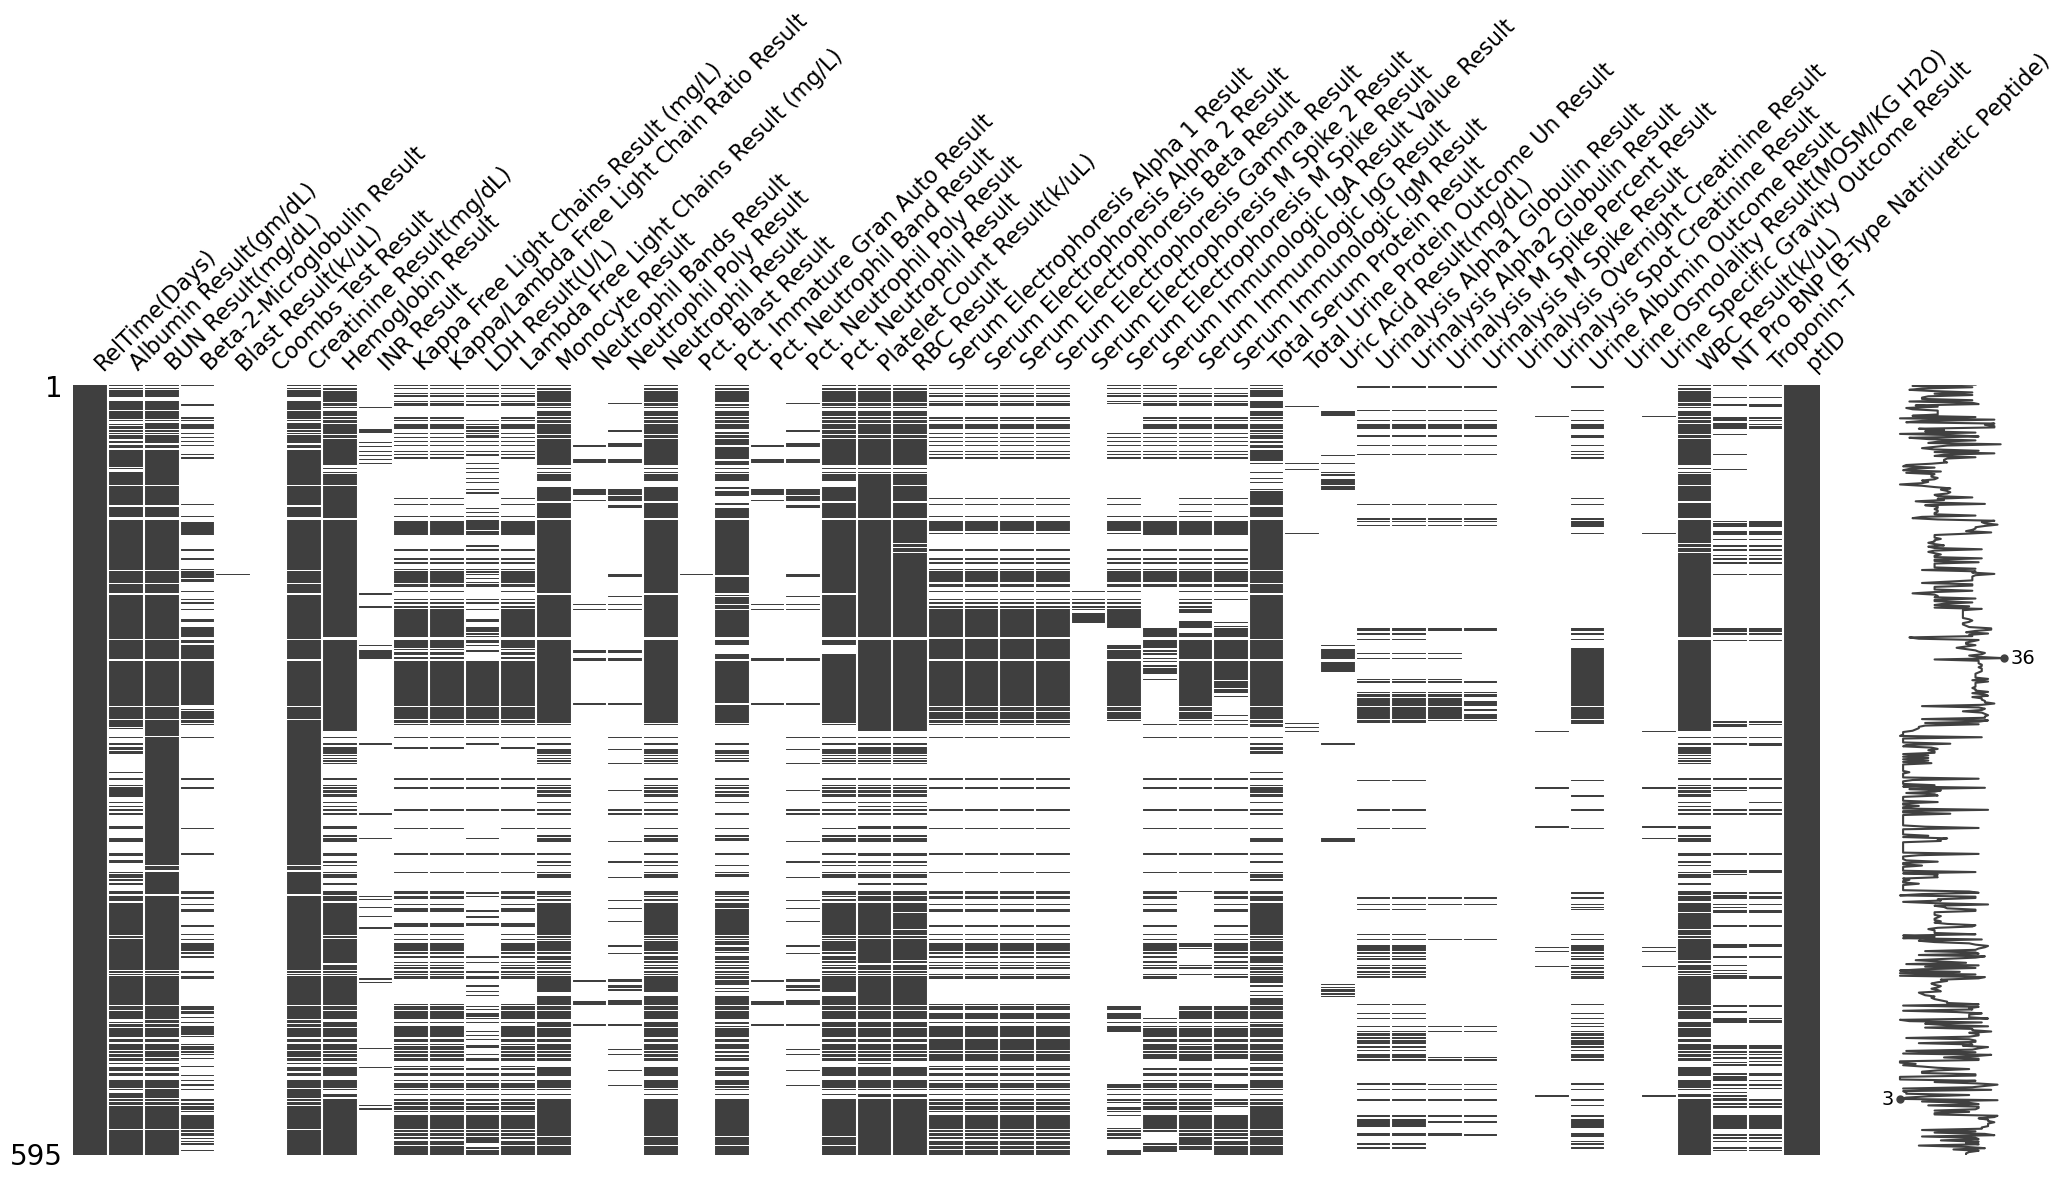

In [18]:
msno.matrix(df_ALStatus_labs)

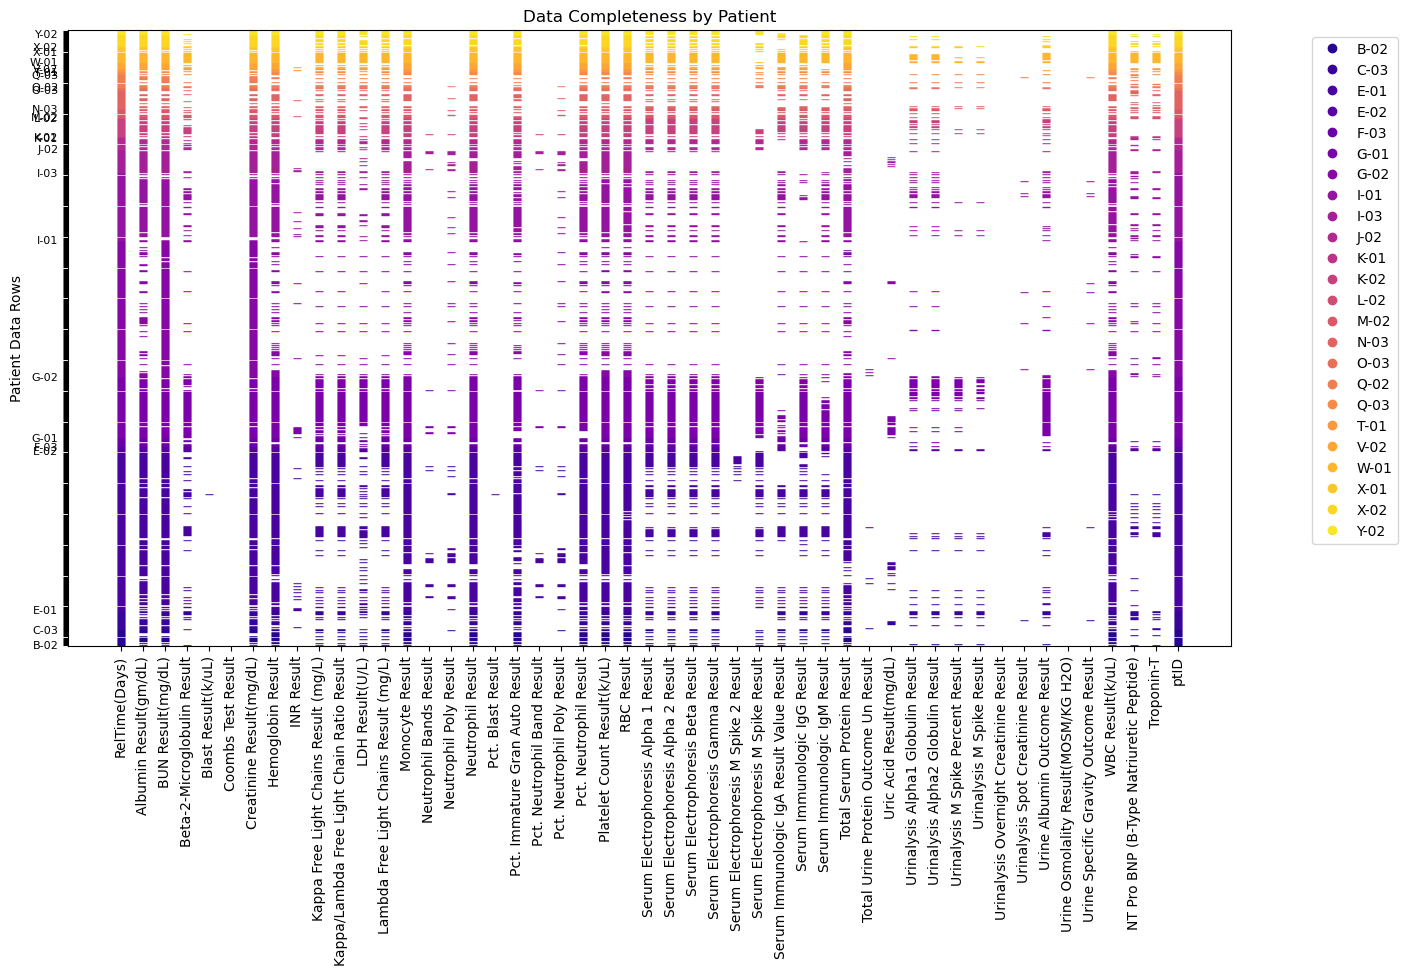

In [60]:
# Create a DataFrame to indicate the presence (1) or absence (0) of data
presence_matrix = df_ALStatus_labs.notnull().astype(int)

# Generate a color palette with a unique color for each patient
unique_patients = df_ALStatus_labs['ptID'].unique()
num_patients = len(unique_patients)
palette = sns.color_palette("plasma", num_patients)
patient_color_map = {patient: palette[i] for i, patient in enumerate(unique_patients)}

# Create a matrix plot
# fig = plt.figure(figsize= (20, 8))
# ax = plt.subplot2grid((1,2), (0,0))
fig, ax = plt.subplots(figsize=(15, 8))

# Plot each row of data, coloring by patient and highlighting null values
for idx, row in df_ALStatus_labs.iterrows():
    ptID = row['ptID']
    color = patient_color_map[ptID]
    y_values = presence_matrix.loc[idx].values
    for j, value in enumerate(y_values):
        if value == 1:
            ax.plot(j, idx, '_', color=color)
        else:
            ax.plot(j, idx, '_', color='white', markersize=10)

# Customize the plot
ax.set_xticks(range(len(presence_matrix.columns))) 
ax.set_xticklabels(presence_matrix.columns, rotation = 'vertical')  
# Create y-tick labels only for the first instance of each patient
y_ticks = []
y_ticklabels = []
for i in range(len(df_ALStatus_labs)):
    if i == 0 or df_ALStatus_labs['ptID'].iloc[i] != df_ALStatus_labs['ptID'].iloc[i - 1]:
        y_ticks.append(i)
        y_ticklabels.append(df_ALStatus_labs['ptID'].iloc[i])
    else:
        y_ticks.append(i)
        y_ticklabels.append('')

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticklabels, size = 8)
# ax.set_xlabel('Lab Results')
ax.set_ylabel('Patient Data Rows')
ax.set_ylim([-1, len(df_ALStatus_labs)])
ax.legend(handles=[plt.Line2D([0], [0], marker='o', color=palette[i], label=unique_patients[i], linestyle='') 
                   for i in range(num_patients)], loc='upper right', bbox_to_anchor=(1.15, 1))

ax.set_title('Data Completeness by Patient')


# Add sparklines to the right of the matrix plot
#correct the above to use subplot2grid
#add the spark lines using the sum of binary across a row.  plot those using the patient color
# columnsForNewDataframe = ["ptID", x_column_name]
# columnsForNewDataframe = columnsForNewDataframe.append(columnNames)
# df_ALStatus_labs_binarysums = pd.DataFrame(columns = columnsForNewDataframe)

# #get the total number of labs binary to sort the columns

# df_ALStatus_labs_all_binarysum = createBinarySum(df_ALStatus_labs, columnNames, x_column_name)

# #plot the binary sum by patient
# bottom = np.zeros(len(columnNames))

# #figure
# ax3 = plt.subplot2grid((1,2), (0,1))

# for ptID in listPositive:
#     #get patient section of frame
#     ptDatatoPlot = patientSectionOfFrame(df_ALStatus_labs, column_toMask='ptID', ptID=ptID)
#     ptDataToPlot_binary = createBinarySum(ptDatatoPlot, columnNames, x_column_name, defaxis= 1)
#     color = patient_color_map[ptID]
#     df_ALStatus_labs_binarysums = df_ALStatus_labs_binarysums._append(ptDataToPlot_binary, ignore_index = True)
#     p= ax3.bar(columnNames, ptDataToPlot_binary, width = 0.8, 
#               label = columnNames, color = color,
#               bottom = bottom)
#     bottom = bottom + ptDataToPlot_binary

plt.show()

#save this output


C:\Users\maega\AppData\Local\Temp\ipykernel_20616\3683311999.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(sortedColumnNames.index, rotation = 'vertical')


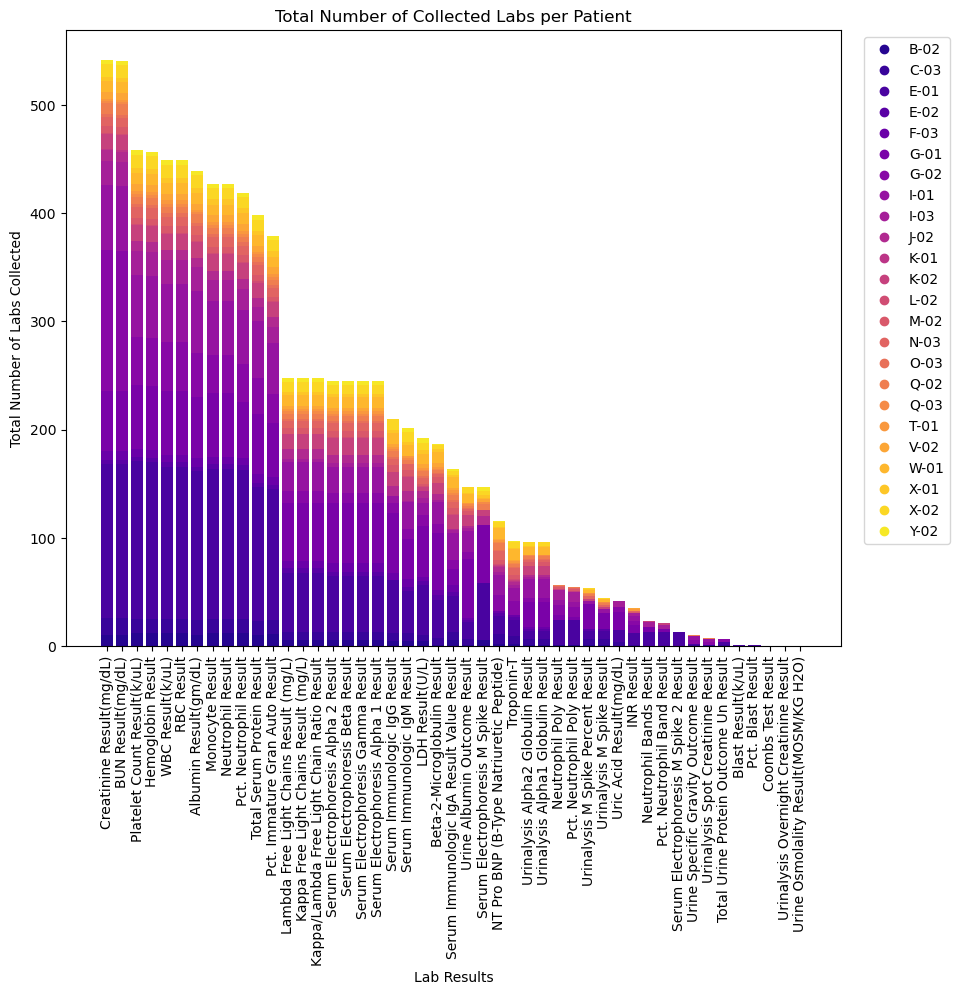

In [59]:

#create a stacked bar plot for the same data 
# Plot each row of data, coloring by patient and highlighting null values
fig, ax2=plt.subplots(figsize=(10,8))
# ax2 = plt.subplot2grid((1,2), (0,1))
def createBinarySum(df, listOfLabs, timeColumn, defaxis):
    #list of labs needs to match exactly.  
    # Filter the dataframe before inputting
    #for boolean
    df_toBool = df[listOfLabs]
    df_bool = df_toBool.notna()
    df_asint = df_bool.astype(int)
    #add column back for time 
    # df_asint.insert(0, timeColumn, df[timeColumn])
    #sum across the row
    #defaxis = 0 means the columns are preserved 
    #defaxis =1 means the rows are preserved
    df_new_sum = df_asint.sum(axis = defaxis)
    return df_new_sum

columnsForNewDataframe = ["ptID", x_column_name]
columnsForNewDataframe = columnsForNewDataframe.append(columnNames)
df_ALStatus_labs_binarysums = pd.DataFrame(columns = columnsForNewDataframe)

#get the total number of labs binary to sort the columns

df_ALStatus_labs_all_binarysum = createBinarySum(df_ALStatus_labs, columnNames, x_column_name, defaxis= 0)
#now sort the columns
sortedColumnNames = df_ALStatus_labs_all_binarysum.sort_values(axis=0, ascending=False)

bottom = np.zeros(len(sortedColumnNames))
for ptID in listPositive:
    #get patient section of frame
    ptDatatoPlot = patientSectionOfFrame(df_ALStatus_labs, column_toMask='ptID', ptID=ptID)
    ptDataToPlot_binary = createBinarySum(ptDatatoPlot, sortedColumnNames.index, x_column_name, defaxis = 0)
    color = patient_color_map[ptID]
    df_ALStatus_labs_binarysums = df_ALStatus_labs_binarysums._append(ptDataToPlot_binary, ignore_index = True)
    p= ax2.bar(sortedColumnNames.index, ptDataToPlot_binary, width = 0.8, 
              label = sortedColumnNames.index, color = color,
              bottom = bottom)
    bottom = bottom + ptDataToPlot_binary


# ax.set_xticks(ax.get_xticks)
ax2.set_xticklabels(sortedColumnNames.index, rotation = 'vertical')

ax2.set_xlabel('Lab Results')
ax2.set_ylabel('Total Number of Labs Collected')
ax2.legend(handles=[plt.Line2D([0], [0], marker='o', color=palette[i], label=unique_patients[i], 
                              linestyle='') for i in range(num_patients)], loc='upper right',  
                              bbox_to_anchor=(1.15, 1))

ax2.set_title("Total Number of Collected Labs per Patient")
plt.show()

#save this output